# Search for genes bearing combined selection signals

Initial data: dataframe with metrics for all genes in human genome (without mitochondrial genome)

57783 genes * 32 metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import os
from venn import venn

In [2]:
current_dir = os.getcwd()
path_to_data = os.path.abspath(os.path.join(current_dir, '..', 'data', 'merged_data',
                                            'css_project_metrics.tsv'))

df = pd.read_csv(path_to_data, sep='\t')

# Filtering genes and Venn Diagramm

- For RS and LOEUF, mark all genes within the top decile (top 10% of values) as bearing a selection signal (“high RS”, “low LOEUF”)

- For iHS, mark genes with significant maximum values using the computed gene-wise maximum p-value corrected for FDR (adjusted p-value < 0.05)

- For DRC150, use source data files to collect SNPs with FDR adjusted p-valeu < 0.05 (or, if there are few such variants, nominal p-value < 0.001), and then intersect the resulting variants with genes to find which genes contain AT_LEAST_ONE significant SNP

- Draw a Venn Diagram of genes obtained using the 4 metrics (RS, LOEUF, iHS, DRC150), test overlap (see below, in (d));

- To get genes with combined selection signals, use the condition (high_RS OR low_LOEUF) AND (significant_gene_iHS OR has_at_least_one_significant_DRC150_SNP)


In [4]:
#make dfs with conditions
#interpolation='linear' for similarity of results in python and R

df_RS_high = df[df['RS_500_value'] >= df['RS_500_value'].quantile(0.9, interpolation='linear')]
# df.nlargest(int(df.shape[0]*0.1), ['RS_500_value'])


#df.nlargest(int(df.shape[0]*0.1), ['RS_500_value'])
#df.nsmallest(int(df.shape[0]*0.1), ['oe_lof_upper'])

df_loeuf_low = df[df['oe_lof_upper'] <= df['oe_lof_upper'].quantile(0.1, interpolation='linear')]
# df.nsmallest(int(df.shape[0]*0.1), ['oe_lof_upper'])

df_iHS = df.query('pval_iHS_max_fdr < 0.05')

df_drc = df.query('DRC150_signif_snp_count > 0')

In [5]:
print(f'Genes with RS_high: {df_RS_high.shape[0]}')
print(f'Genes with loeuf_low: {df_loeuf_low.shape[0]}')
print(f'Genes with significiant iHS: {df_iHS.shape[0]}')
print(f'Genes with significiant drc: {df_drc.shape[0]}')

Genes with RS_high: 5779
Genes with loeuf_low: 1928
Genes with significiant iHS: 911
Genes with significiant drc: 188


To get genes with combined selection signals, use the condition (high_RS OR low_LOEUF) AND (significant_gene_iHS OR has_at_least_one_significant_DRC150_SNP)


##### Venn diagramm

<Figure size 900x900 with 0 Axes>

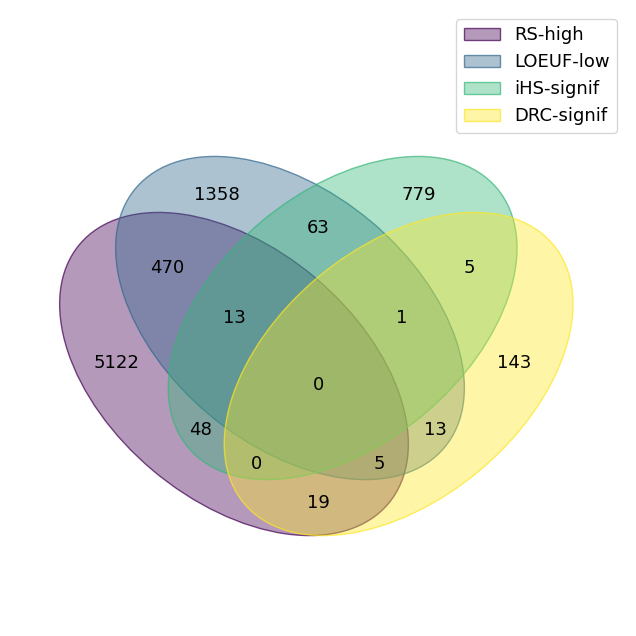

In [7]:
df_RS_high_genes = set(df_RS_high['gene_name'].unique())
df_loeuf_low_genes = set(df_loeuf_low['gene_name'].unique())
df_iHS_genes = set(df_iHS['gene_name'].unique())
df_drc_genes = set(df_drc['gene_name'].unique())

venn_data = {
    "RS-high": df_RS_high_genes,
    "LOEUF-low": df_loeuf_low_genes,
    "iHS-signif": df_iHS_genes,
    "DRC-signif": df_drc_genes
}

plt.figure(figsize=(3, 3), dpi=300)
venn(venn_data)
#plt.savefig('venn.png', dpi=300, bbox_inches='tight') 
plt.show()

In [9]:
genes_with_combined_signals = list((df_RS_high_genes | df_loeuf_low_genes) & (df_iHS_genes | df_drc_genes))
len(genes_with_combined_signals)

162

##### Filtering

In [28]:
#making df for each group of genes

negative_sel = pd.merge(df_RS_high, df_loeuf_low, how='outer')
negative_sel.drop_duplicates(inplace=True)

positive_sel = pd.merge(df_iHS, df_drc, how='outer')
positive_sel.drop_duplicates(inplace=True)

combined = pd.merge(negative_sel, positive_sel, how='inner')
path_to_combined = os.path.join(current_dir, '..', 'data', 'css_filtered_genes.tsv')
#combined.to_csv(path_to_combined, index=False, sep='\t')

##### Mann-Whitney U test between groups

In [23]:
df_go_bp = df['GO_BP_Count'].dropna().to_list()
df_go_mf = df['GO_MF_Count'].dropna().to_list()
css_go_bp = combined['GO_BP_Count'].dropna().to_list()
css_go_mf = combined['GO_MF_Count'].dropna().to_list()

test_on_bp = stats.mannwhitneyu(df_go_bp, css_go_bp)
test_on_mf = stats.mannwhitneyu(df_go_mf, css_go_mf)

print(f'Mann-Whitney U test between df_go_bp and css_go_bp : p-value = {float(test_on_bp[1])}')
print(f'Mann-Whitney U test between df_go_mf and css_go_mf : p-value = {float(test_on_mf[1])}')

Mann-Whitney U test between df_go_bp and css_go_bp : p-value = 3.331401037986378e-08
Mann-Whitney U test between df_go_mf and css_go_mf : p-value = 8.25990962674616e-08


#### Difference between `AND` Operator and `&` Symbol

This is because ‘and‘ tests whether both expressions are logically True while ‘&’ performs bitwise AND operation on the result of both statements.

```python
a = 14
b = 4

print(b and a)  # print_stat1
print(b & a)  # print_stat2

14
4
```

# Statistical testing using Fisher’s exact test 

In [24]:
#create dataframes to count genes
#df_loeuf_low
df_loeuf_not_low = df.drop(df_loeuf_low.index)
#df_iHS
df_iHS_not_sign = df.drop(df_iHS.index)

In [25]:
loeuf_h_iHS_sig = pd.merge(df_loeuf_not_low, df_iHS, how='inner')
print(f'size of loeuf_h_iHS_sig {loeuf_h_iHS_sig.shape}')
loeuf_l_iHS_sig = pd.merge(df_loeuf_low, df_iHS, how='inner')
print(f'size of loeuf_l_iHS_sig {loeuf_l_iHS_sig.shape}')

loeuf_h_iHS_not_sig = pd.merge(df_loeuf_not_low, df_iHS_not_sign, how='inner')
print(f'size of loeuf_h_iHS_not_sig {loeuf_h_iHS_not_sig.shape}')
loeuf_l_iHS_not_sig = pd.merge(df_loeuf_low, df_iHS_not_sign, how='inner')
print(f'size of loeuf_l_iHS_not_sig {loeuf_l_iHS_not_sig.shape}')

size of loeuf_h_iHS_sig (834, 32)
size of loeuf_l_iHS_sig (77, 32)
size of loeuf_h_iHS_not_sig (55021, 32)
size of loeuf_l_iHS_not_sig (1851, 32)


In [27]:
data = [[834, 77], [55021, 1851]] 
  
odd_ratio, p_value = stats.fisher_exact(data) 
print('odd ratio is : ' + str(odd_ratio)) 
print('p_value is : ' + str(p_value)) 

odd ratio is : 0.3643789372511133
p_value is : 1.98867074505834e-13


# Violin plots for different subsets of data

##### GO Biological Process

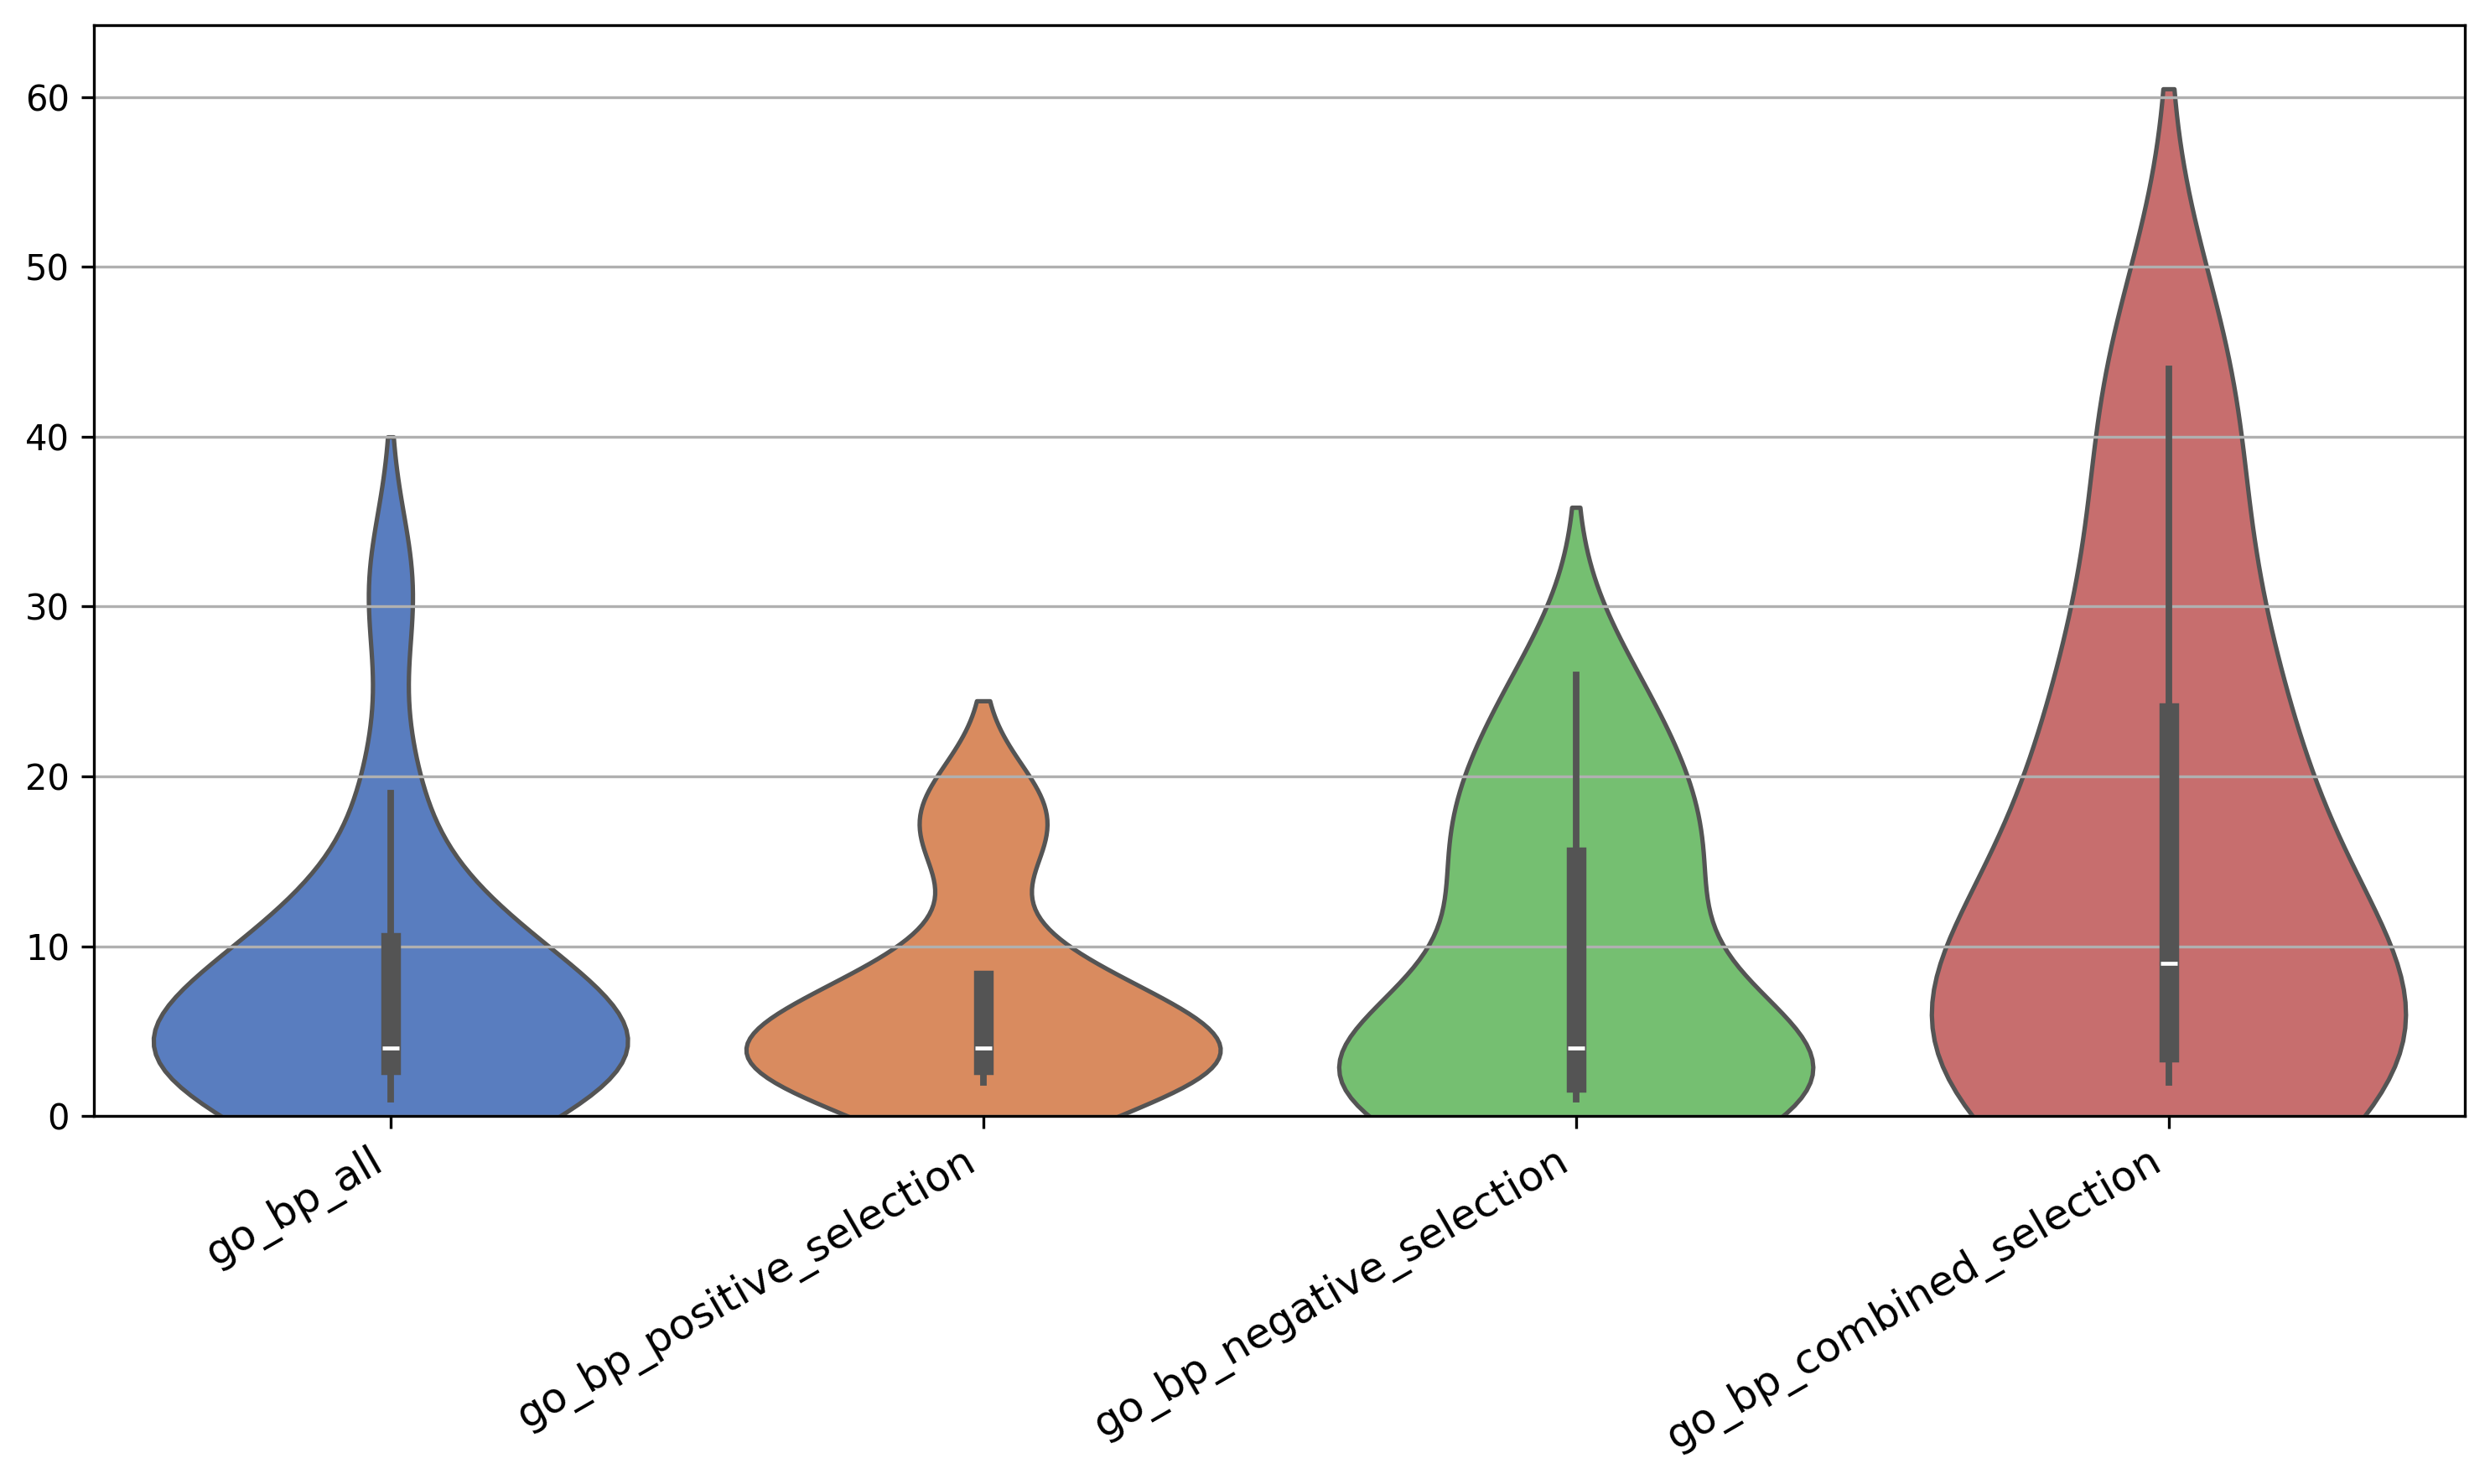

In [38]:
go_bp_all = df['GO_BP_Count']
go_bp_pos = positive_sel['GO_BP_Count']
go_bp_neg = negative_sel['GO_BP_Count']
go_bp_comb = combined['GO_BP_Count']

go_bp_plot = pd.DataFrame({'go_bp_all': pd.Series(go_bp_all), 'go_bp_positive_selection': pd.Series(go_bp_pos),
                        'go_bp_negative_selection': pd.Series(go_bp_neg), 'go_bp_combined_selection': pd.Series(go_bp_comb)})

go_bp_plot = go_bp_plot.query('go_bp_all >= 1 and go_bp_positive_selection >= 1 and go_bp_negative_selection >=1 and go_bp_combined_selection >=1')

plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=go_bp_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

##### GO Molecular Function

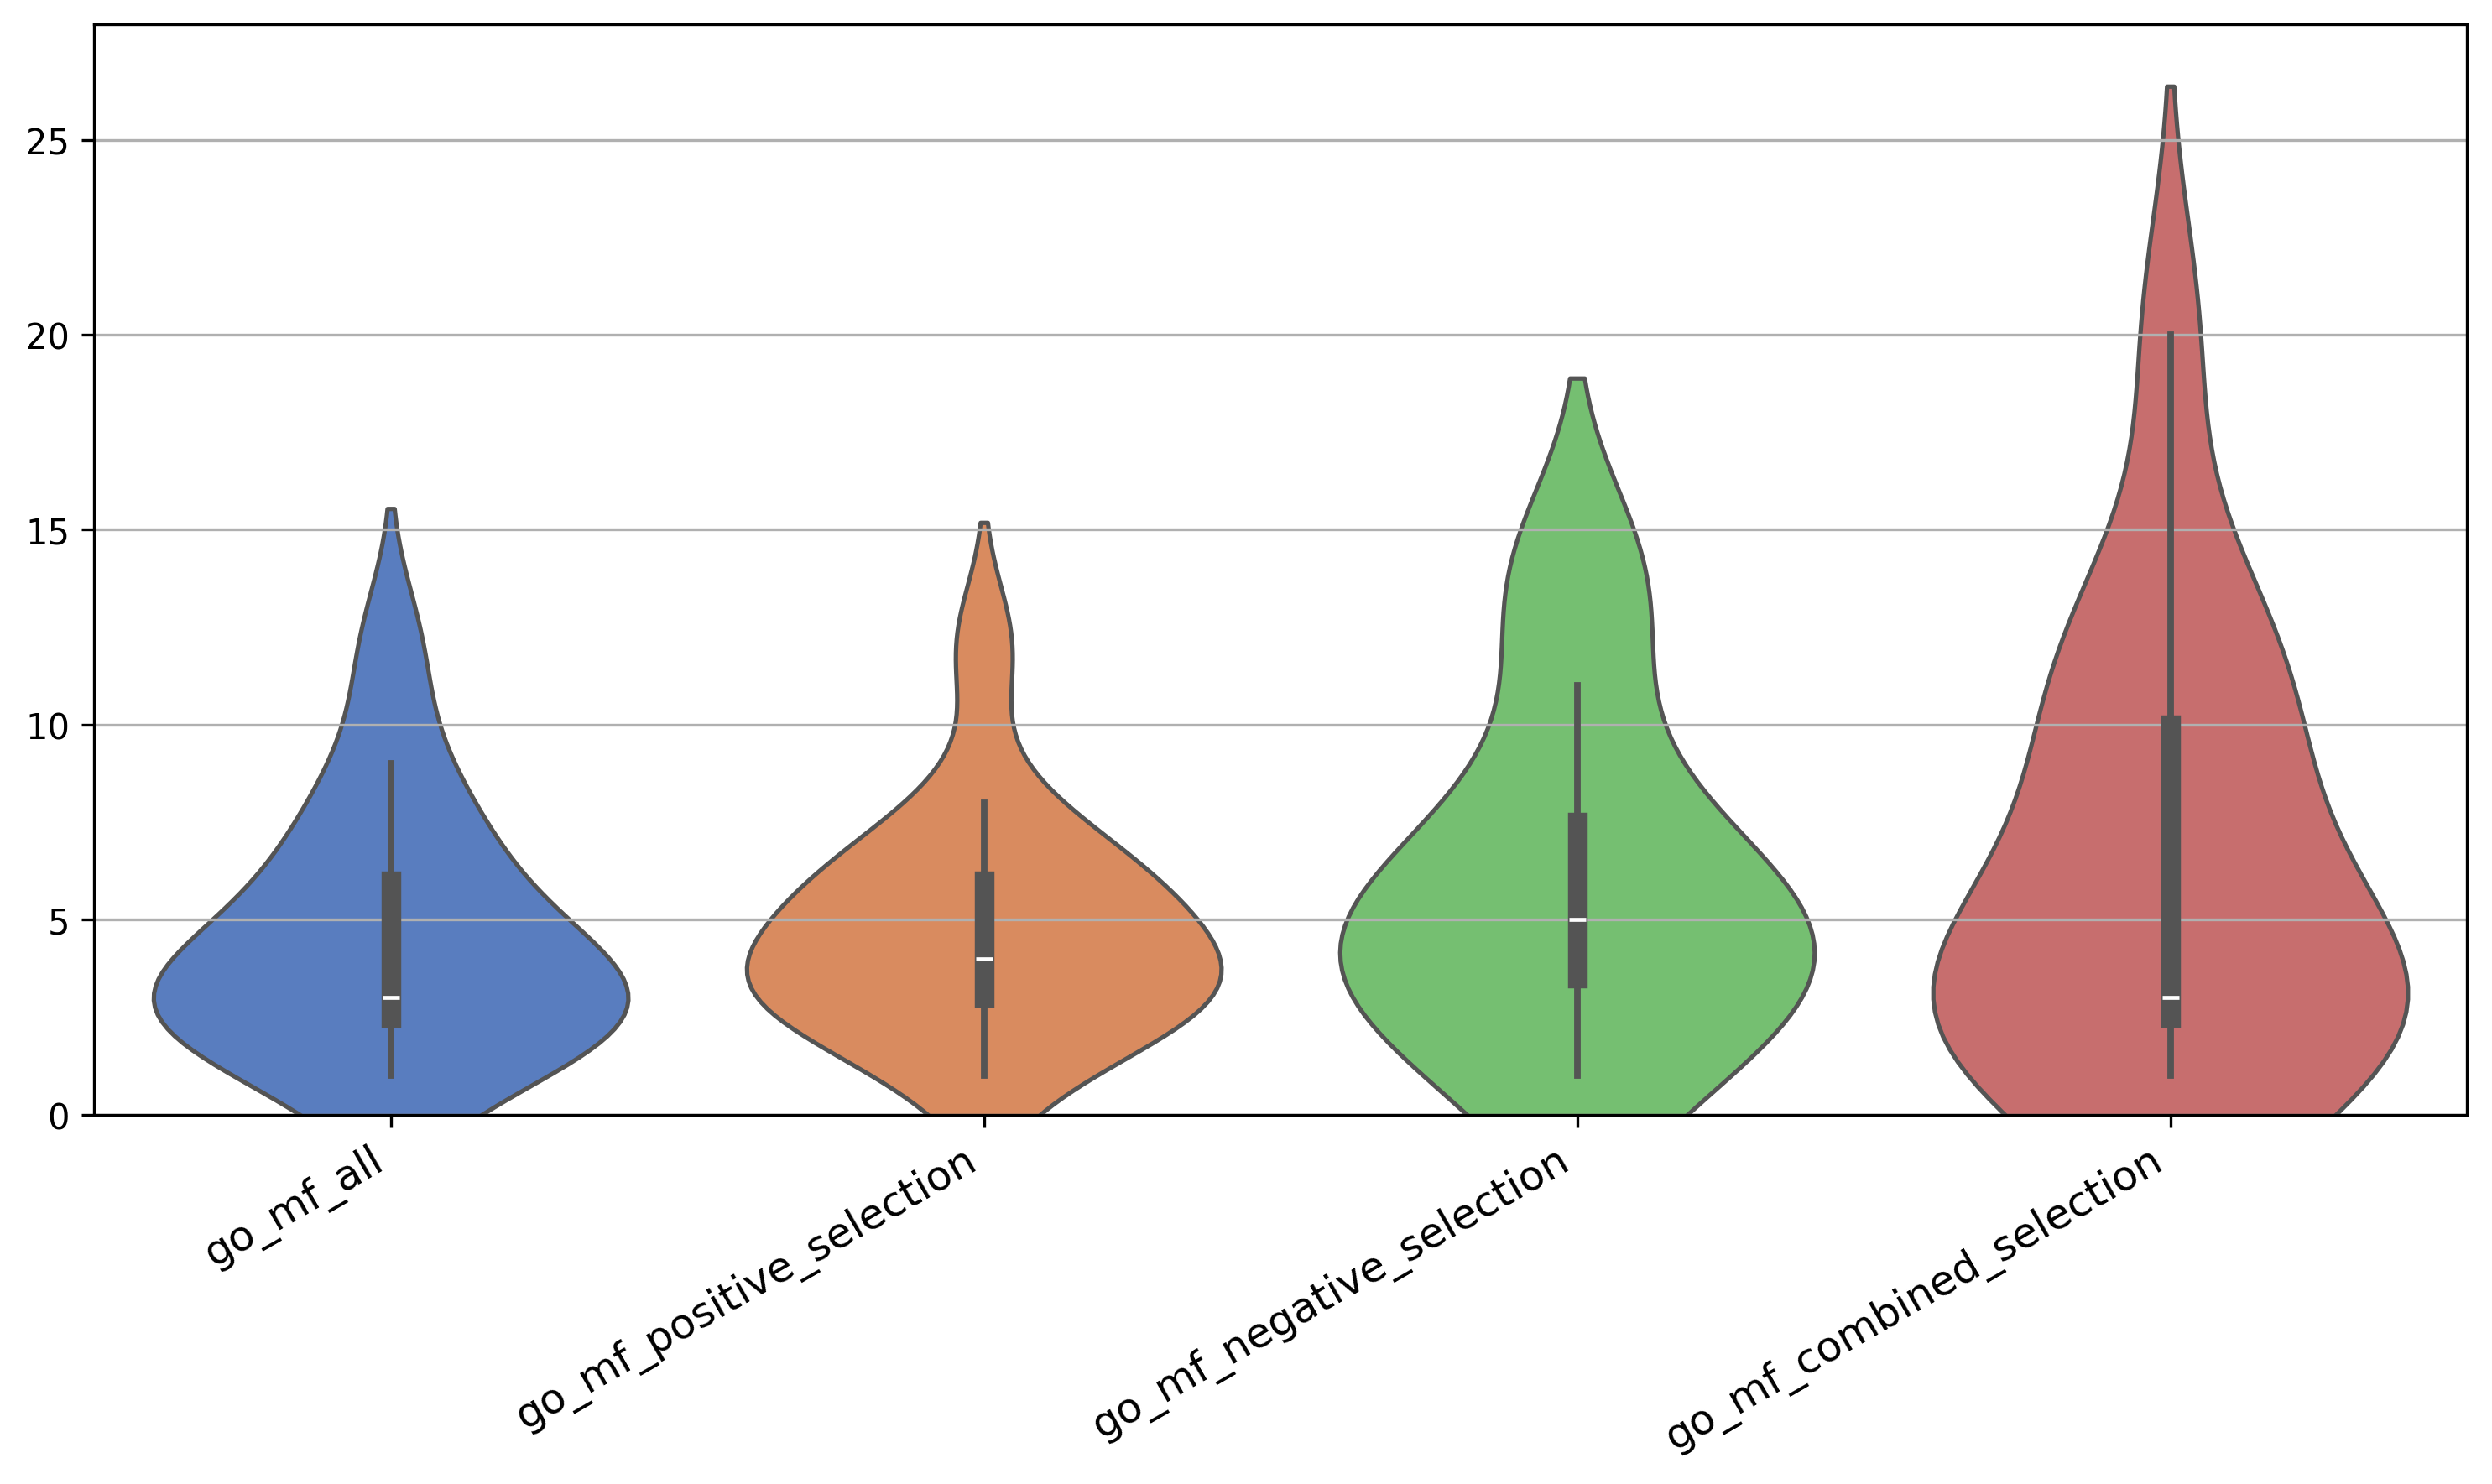

In [15]:
go_mf_all = df['GO_MF_Count']
go_mf_pos = positive_sel['GO_MF_Count']
go_mf_neg = negative_sel['GO_MF_Count']
go_mf_comb = combined['GO_MF_Count']

go_mf_plot = pd.DataFrame({'go_mf_all': pd.Series(go_mf_all), 'go_mf_positive_selection': pd.Series(go_mf_pos),
                        'go_mf_negative_selection': pd.Series(go_mf_neg), 'go_mf_combined_selection': pd.Series(go_mf_comb)})

go_mf_plot = go_mf_plot.query('go_mf_all >= 1 and go_mf_positive_selection >= 1 and go_mf_negative_selection >=1 and go_mf_combined_selection >=1')

plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=go_mf_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

##### BioGRID number of interactions

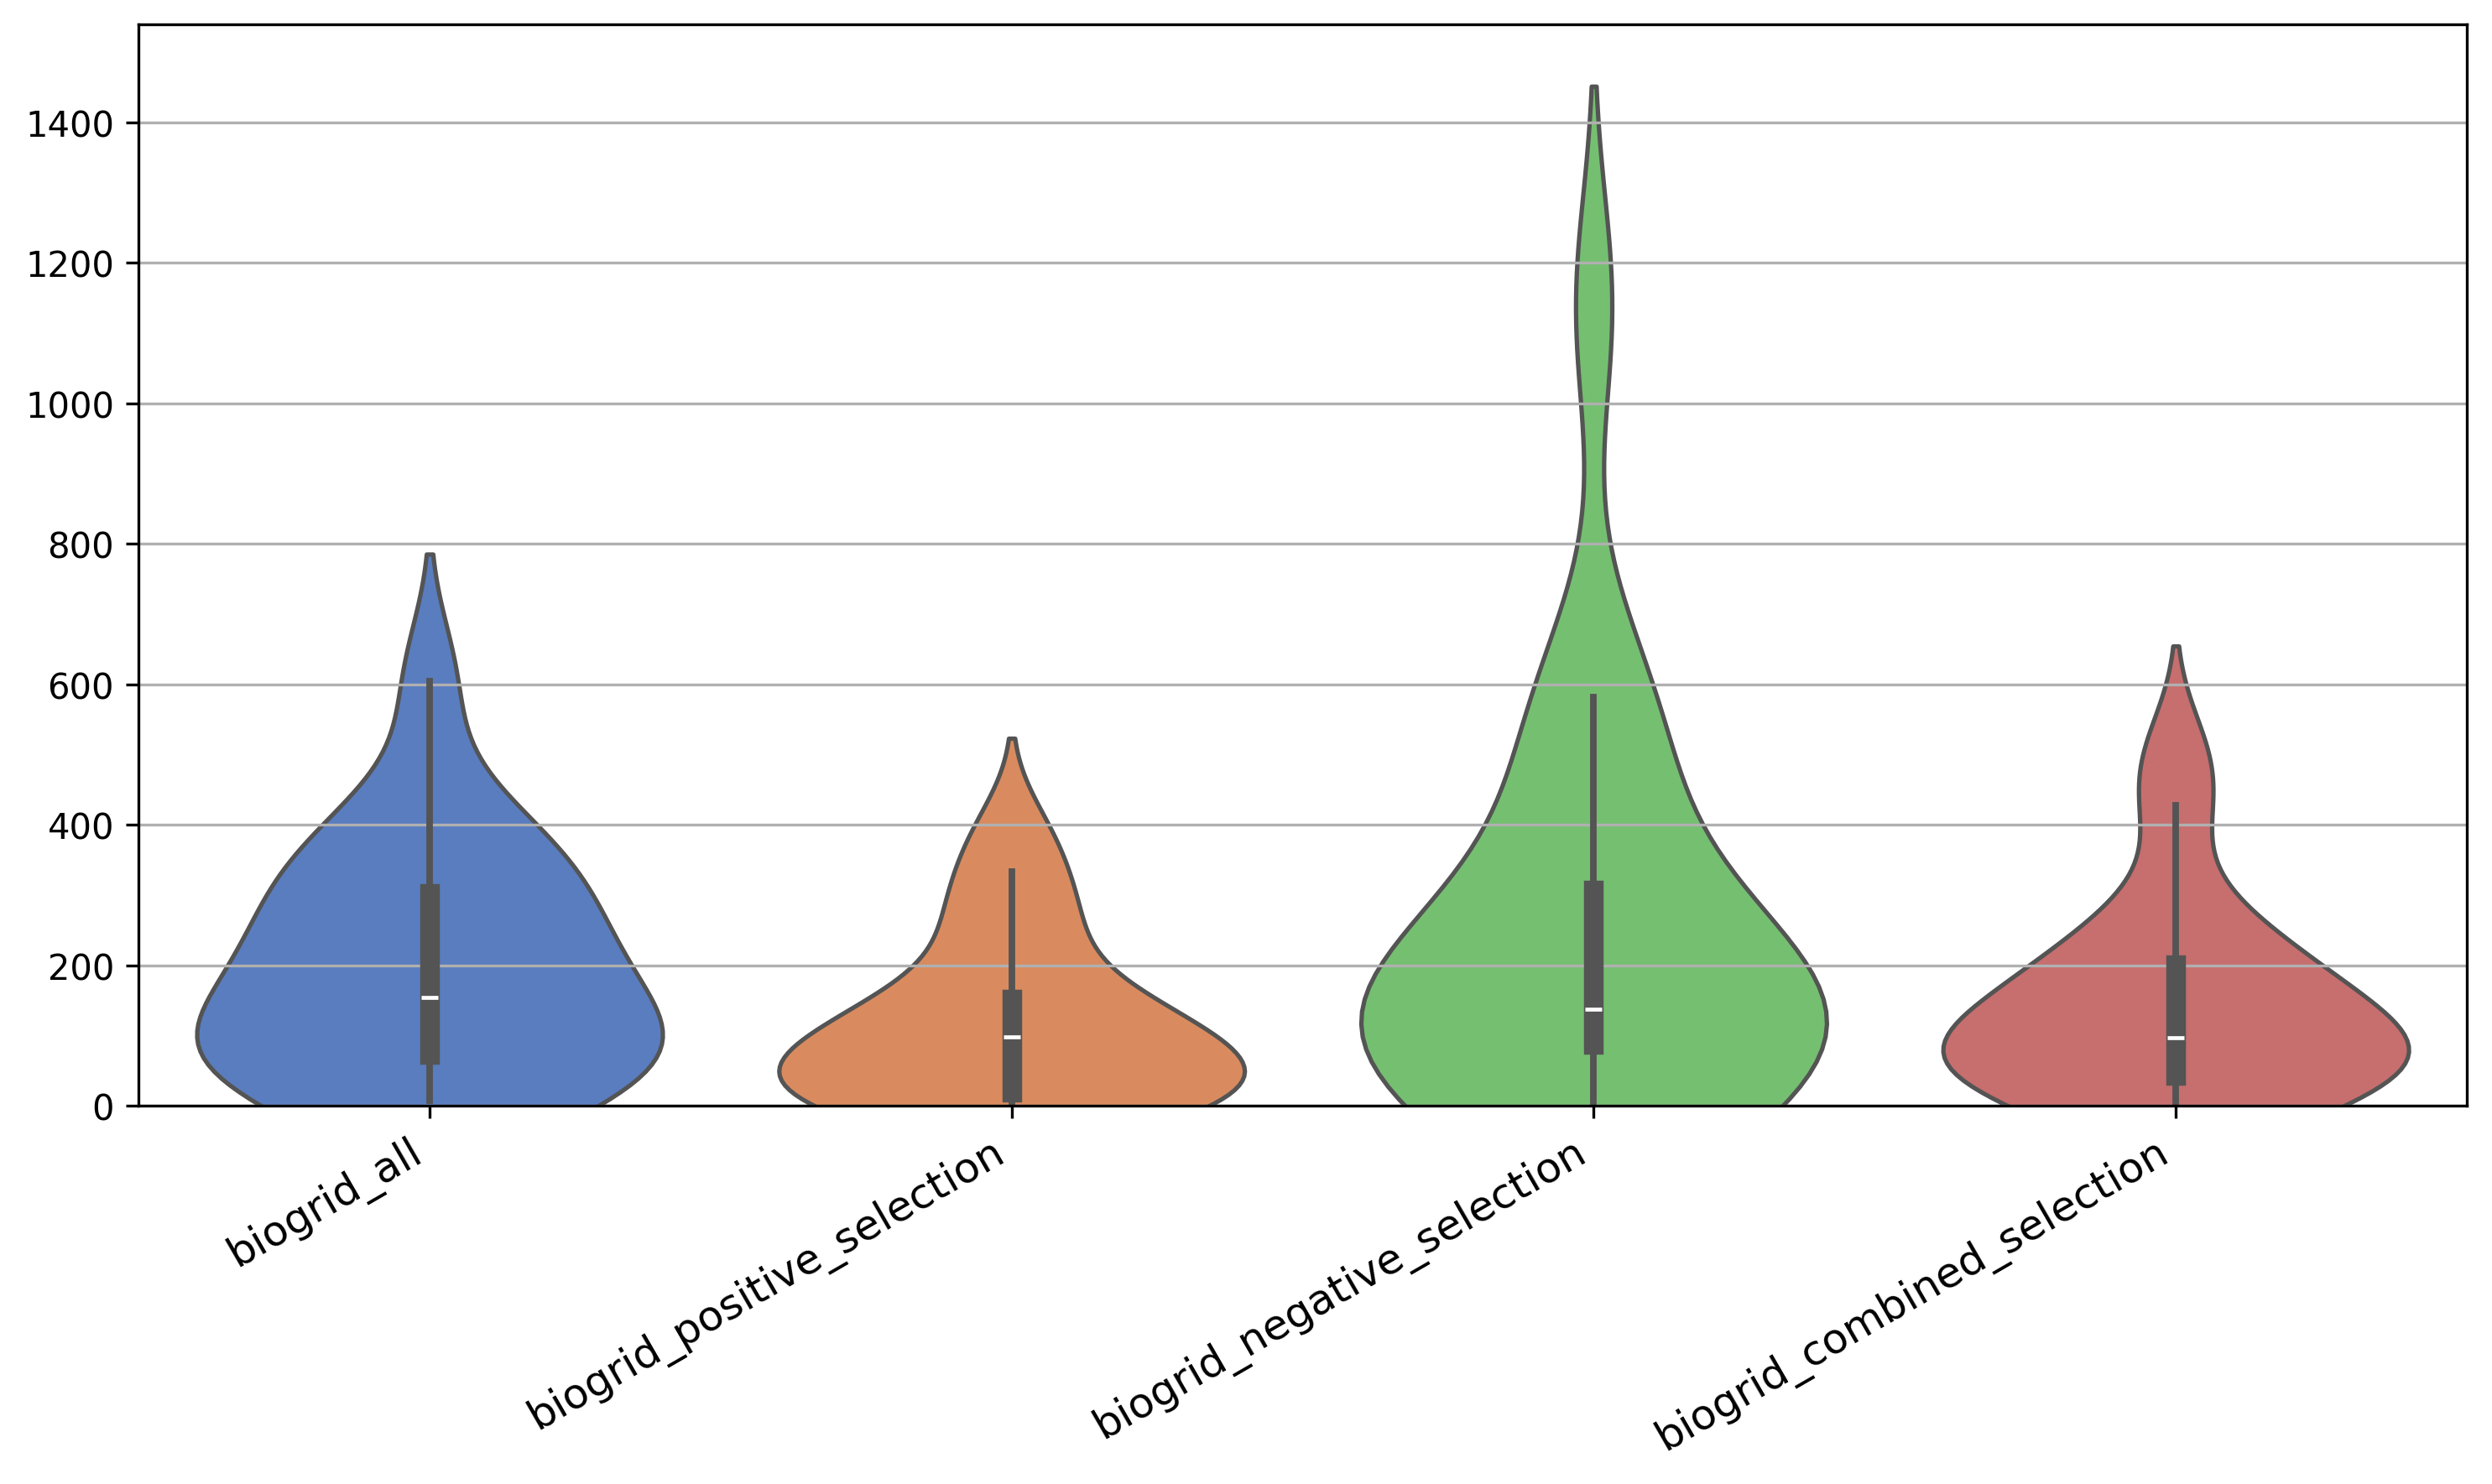

In [39]:
biogrid_all = df['n_interactions']
biogrid_pos = positive_sel['n_interactions']
biogrid_neg = negative_sel['n_interactions']
biogrid_comb = combined['n_interactions']

biogrid_plot = pd.DataFrame({'biogrid_all': pd.Series(biogrid_all), 'biogrid_positive_selection': pd.Series(biogrid_pos),
                        'biogrid_negative_selection': pd.Series(biogrid_neg), 'biogrid_combined_selection': pd.Series(biogrid_comb)})

biogrid_plot = biogrid_plot.query('biogrid_all >= 1 and biogrid_positive_selection >= 1 and biogrid_negative_selection >=1 and biogrid_combined_selection >=1')

plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=biogrid_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

##### GTEx 

In [40]:
gtex_num_all = df['num_tissues_at_least_5_TPM']
gtex_num_pos = positive_sel['num_tissues_at_least_5_TPM']
gtex_num_neg = negative_sel['num_tissues_at_least_5_TPM']
gtex_num_comb = combined['num_tissues_at_least_5_TPM']

gtex_num_plot = pd.DataFrame({'gtex_num_all': pd.Series(gtex_num_all), 'gtex_num_positive_selection': pd.Series(gtex_num_pos),
                        'gtex_num_negative_selection': pd.Series(gtex_num_neg), 'gtex_num_combined_selection': pd.Series(gtex_num_comb)})

In [41]:
gtex_num_plot = gtex_num_plot.query('gtex_num_all >= 1 and gtex_num_positive_selection >= 1 and gtex_num_negative_selection >=1 and gtex_num_combined_selection >=1')

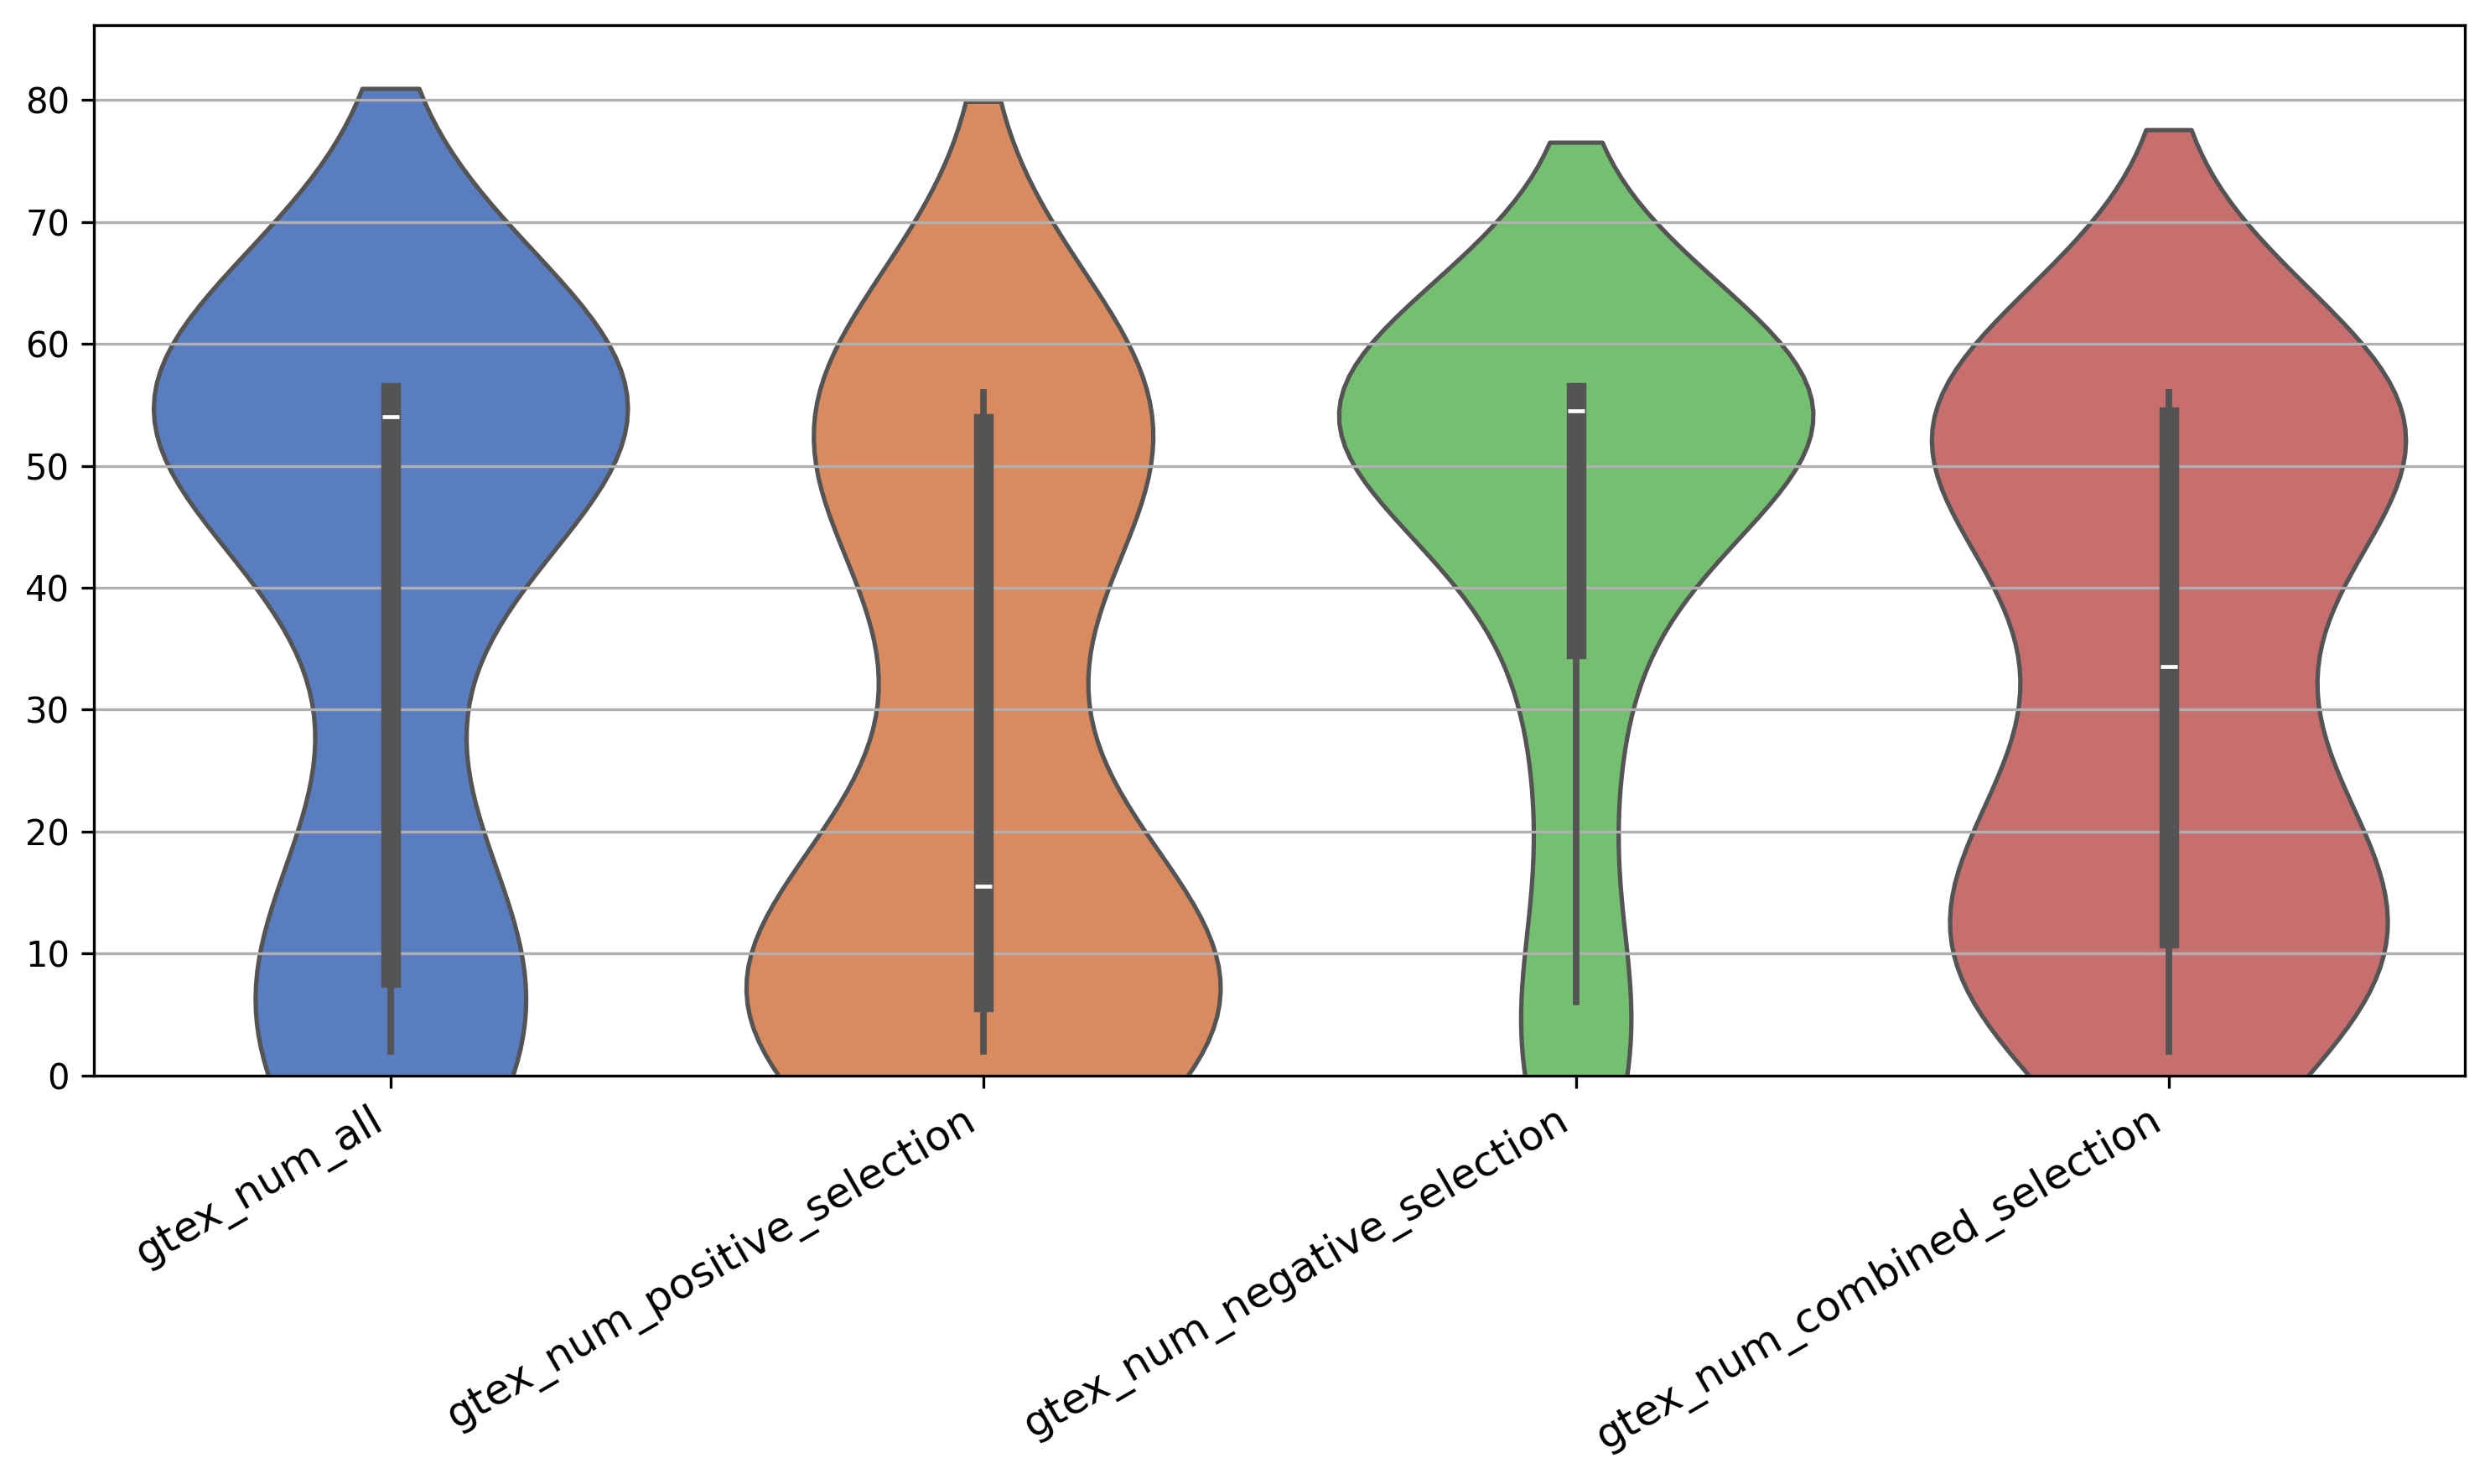

In [42]:
plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=gtex_num_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

GTEx for median

In [43]:
gtex_med_all = df['median_expr_all_tissues']
gtex_med_pos = positive_sel['median_expr_all_tissues']
gtex_med_neg = negative_sel['median_expr_all_tissues']
gtex_med_comb = combined['median_expr_all_tissues']

gtex_med_plot = pd.DataFrame({'gtex_med_all': pd.Series(gtex_med_all), 'gtex_med_positive_selection': pd.Series(gtex_med_pos),
                        'gtex_med_negative_selection': pd.Series(gtex_med_neg), 'gtex_med_combined_selection': pd.Series(gtex_med_comb)})

In [45]:
gtex_med_plot = gtex_med_plot.query('gtex_med_all >= 1 and gtex_med_positive_selection >= 1 and gtex_med_negative_selection >=1 and gtex_med_combined_selection >=1')

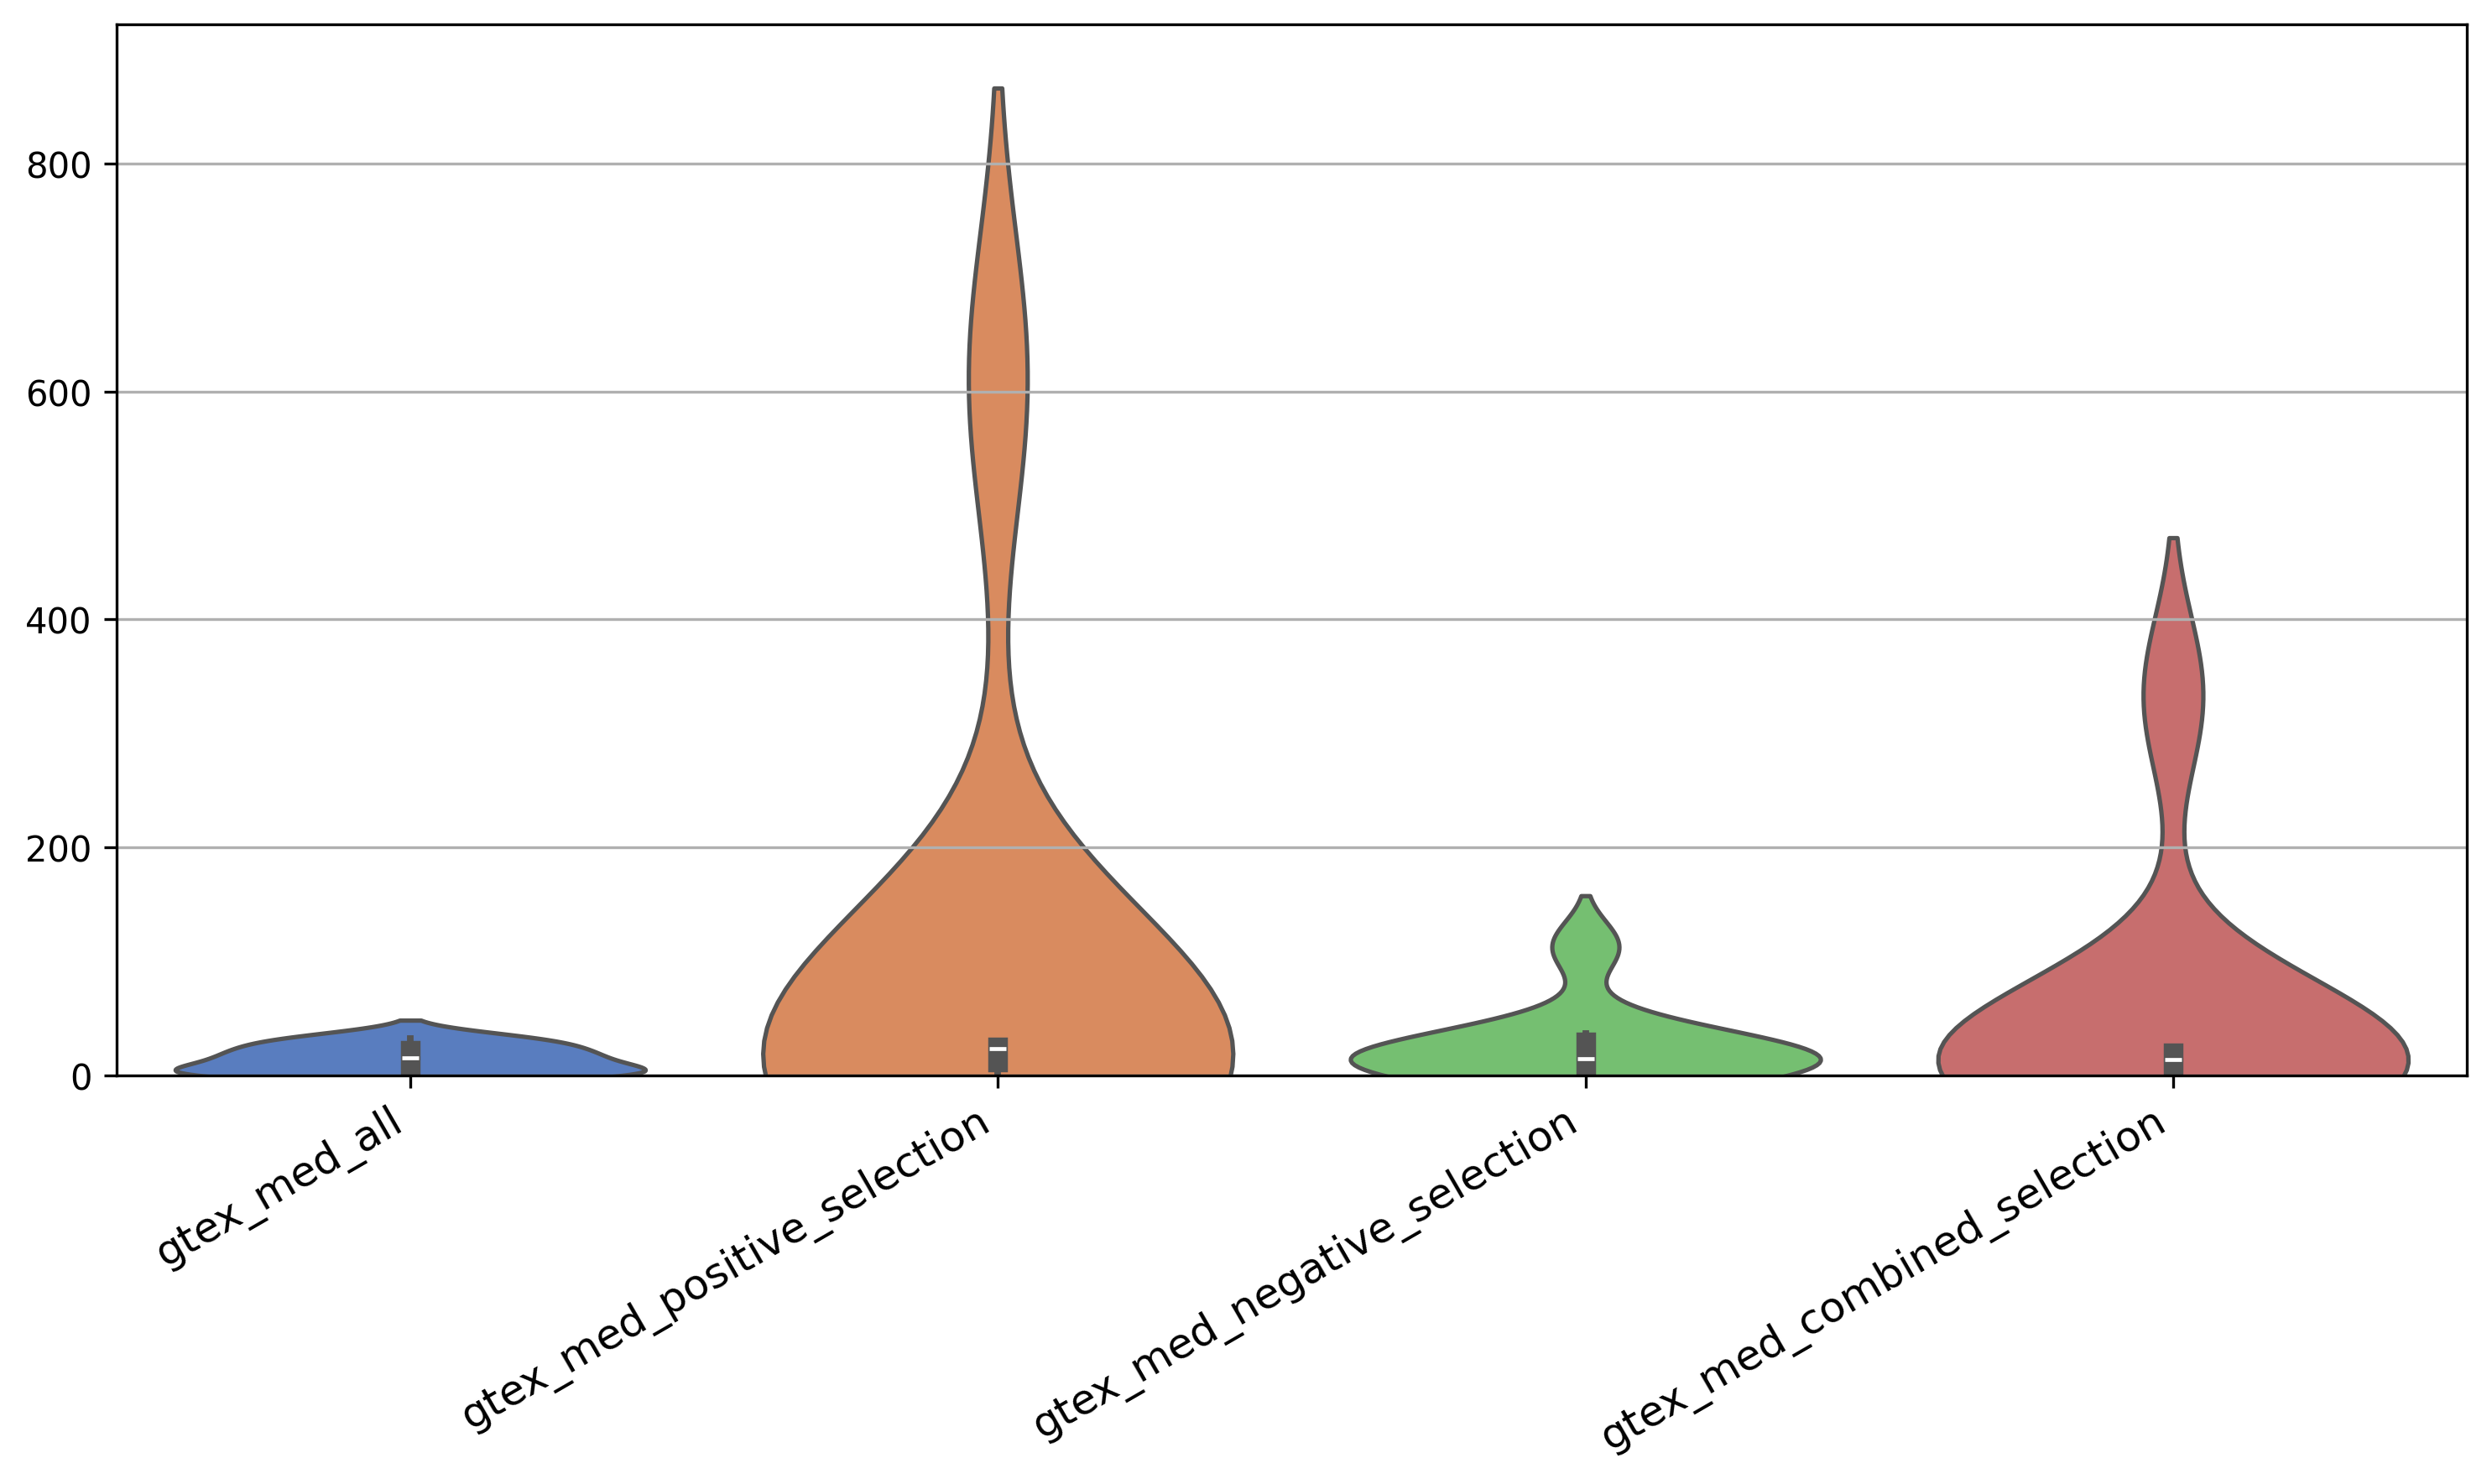

In [46]:
plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=gtex_med_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

GTEx for max

In [47]:
gtex_max_all = df['max_expr_all_tissues']
gtex_max_pos = positive_sel['max_expr_all_tissues']
gtex_max_neg = negative_sel['max_expr_all_tissues']
gtex_max_comb = combined['max_expr_all_tissues']

gtex_max_plot = pd.DataFrame({'gtex_max_all': pd.Series(gtex_max_all), 'gtex_max_positive_selection': pd.Series(gtex_max_pos),
                        'gtex_max_negative_selection': pd.Series(gtex_max_neg), 'gtex_max_combined_selection': pd.Series(gtex_max_comb)})
gtex_max_plot.dropna(inplace=True) 

In [48]:
gtex_max_plot = gtex_max_plot.query('gtex_max_all != 0 and gtex_max_positive_selection != 0 and gtex_max_negative_selection != 0 and gtex_max_combined_selection != 0')
gtex_max_plot.dropna(inplace=True) 

In [49]:
gtex_max_plot = gtex_max_plot.query('gtex_max_all >= 1 and gtex_max_positive_selection >= 1 and gtex_max_negative_selection >=1 and gtex_max_combined_selection >=1')

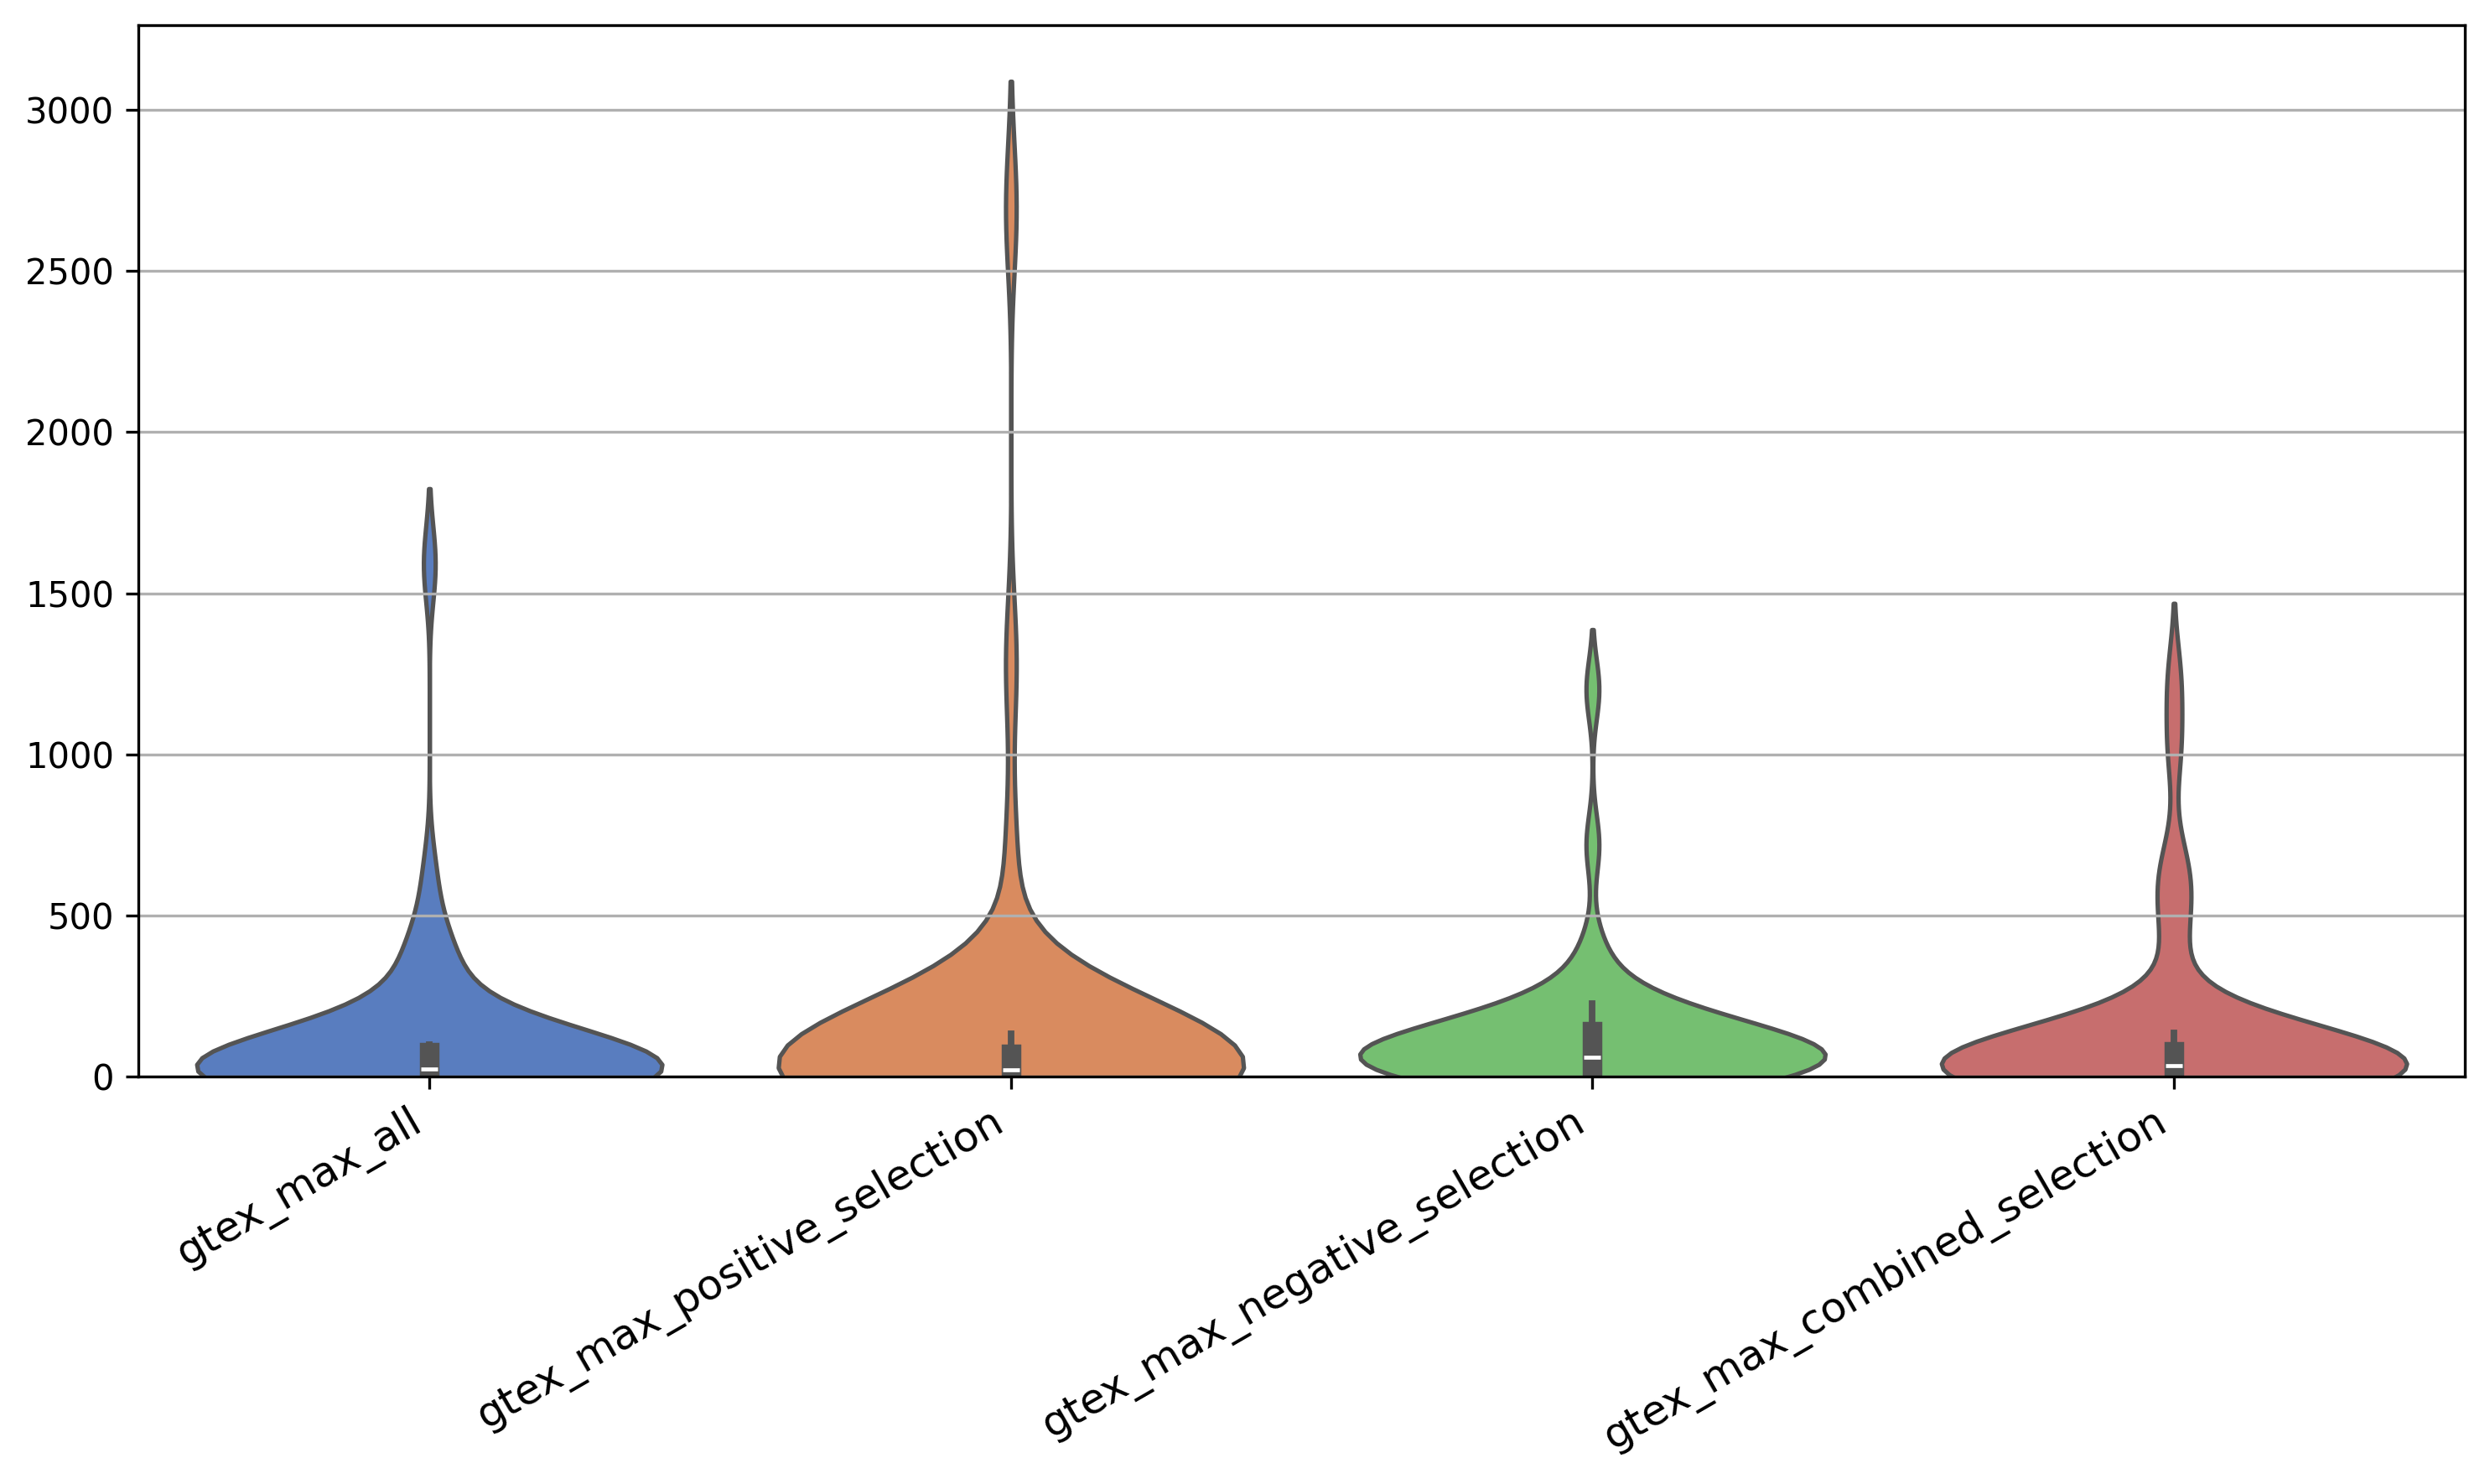

In [50]:
plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=gtex_max_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

##### GERP++ RS

In [82]:
rs_all = df['RS_500_value']
rs_pos = positive_sel['RS_500_value']
rs_neg = negative_sel['RS_500_value']
rs_comb = combined['RS_500_value']

rs_plot = pd.DataFrame({'RS_all': pd.Series(rs_all), 'RS_positive_selection': pd.Series(rs_pos),
                        'RS_negative_selection': pd.Series(rs_neg), 'RS_combined_selection': pd.Series(rs_comb)})

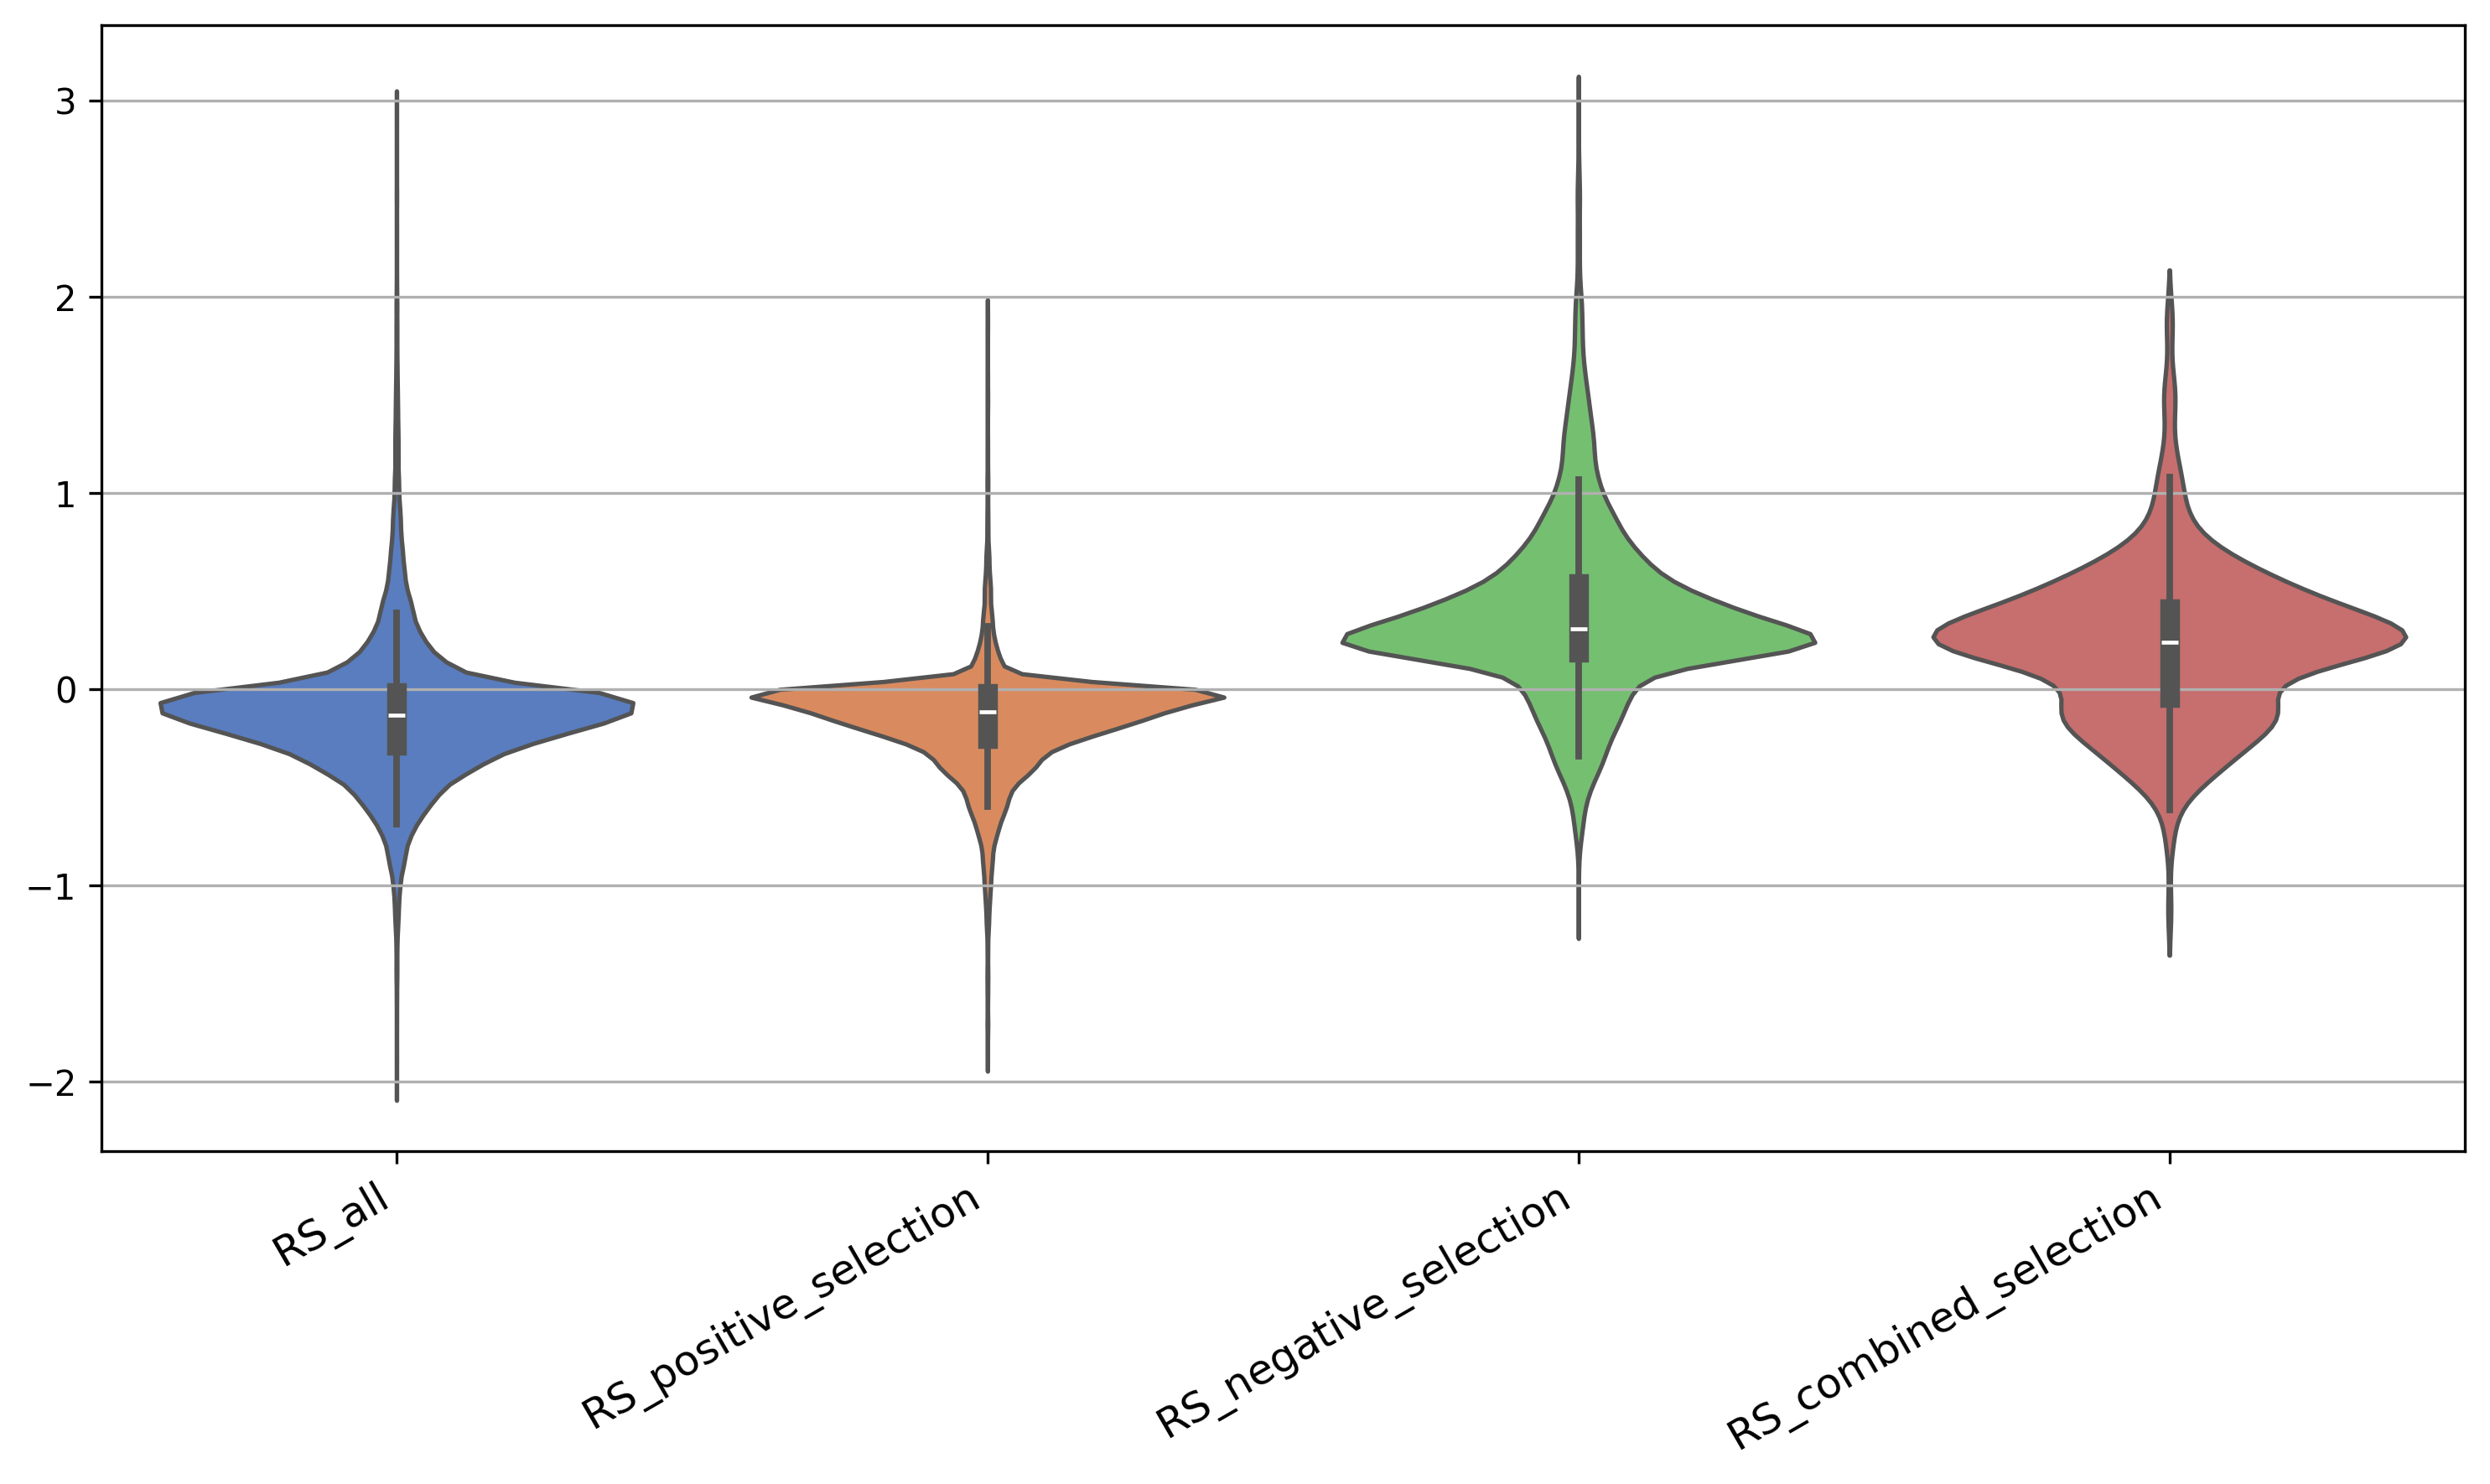

In [83]:
plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=rs_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### LOEUF

In [84]:
oe_all = df['oe_lof_upper']
oe_pos = positive_sel['oe_lof_upper']
oe_neg = negative_sel['oe_lof_upper']
oe_comb = combined['oe_lof_upper']

oe_plot = pd.DataFrame({'LOEUF_all': pd.Series(oe_all), 'LOEUF_positive_selection': pd.Series(oe_pos),
                        'LOEUF_negative_selection': pd.Series(oe_neg), 'LOEUF_combined_selection': pd.Series(oe_comb)})

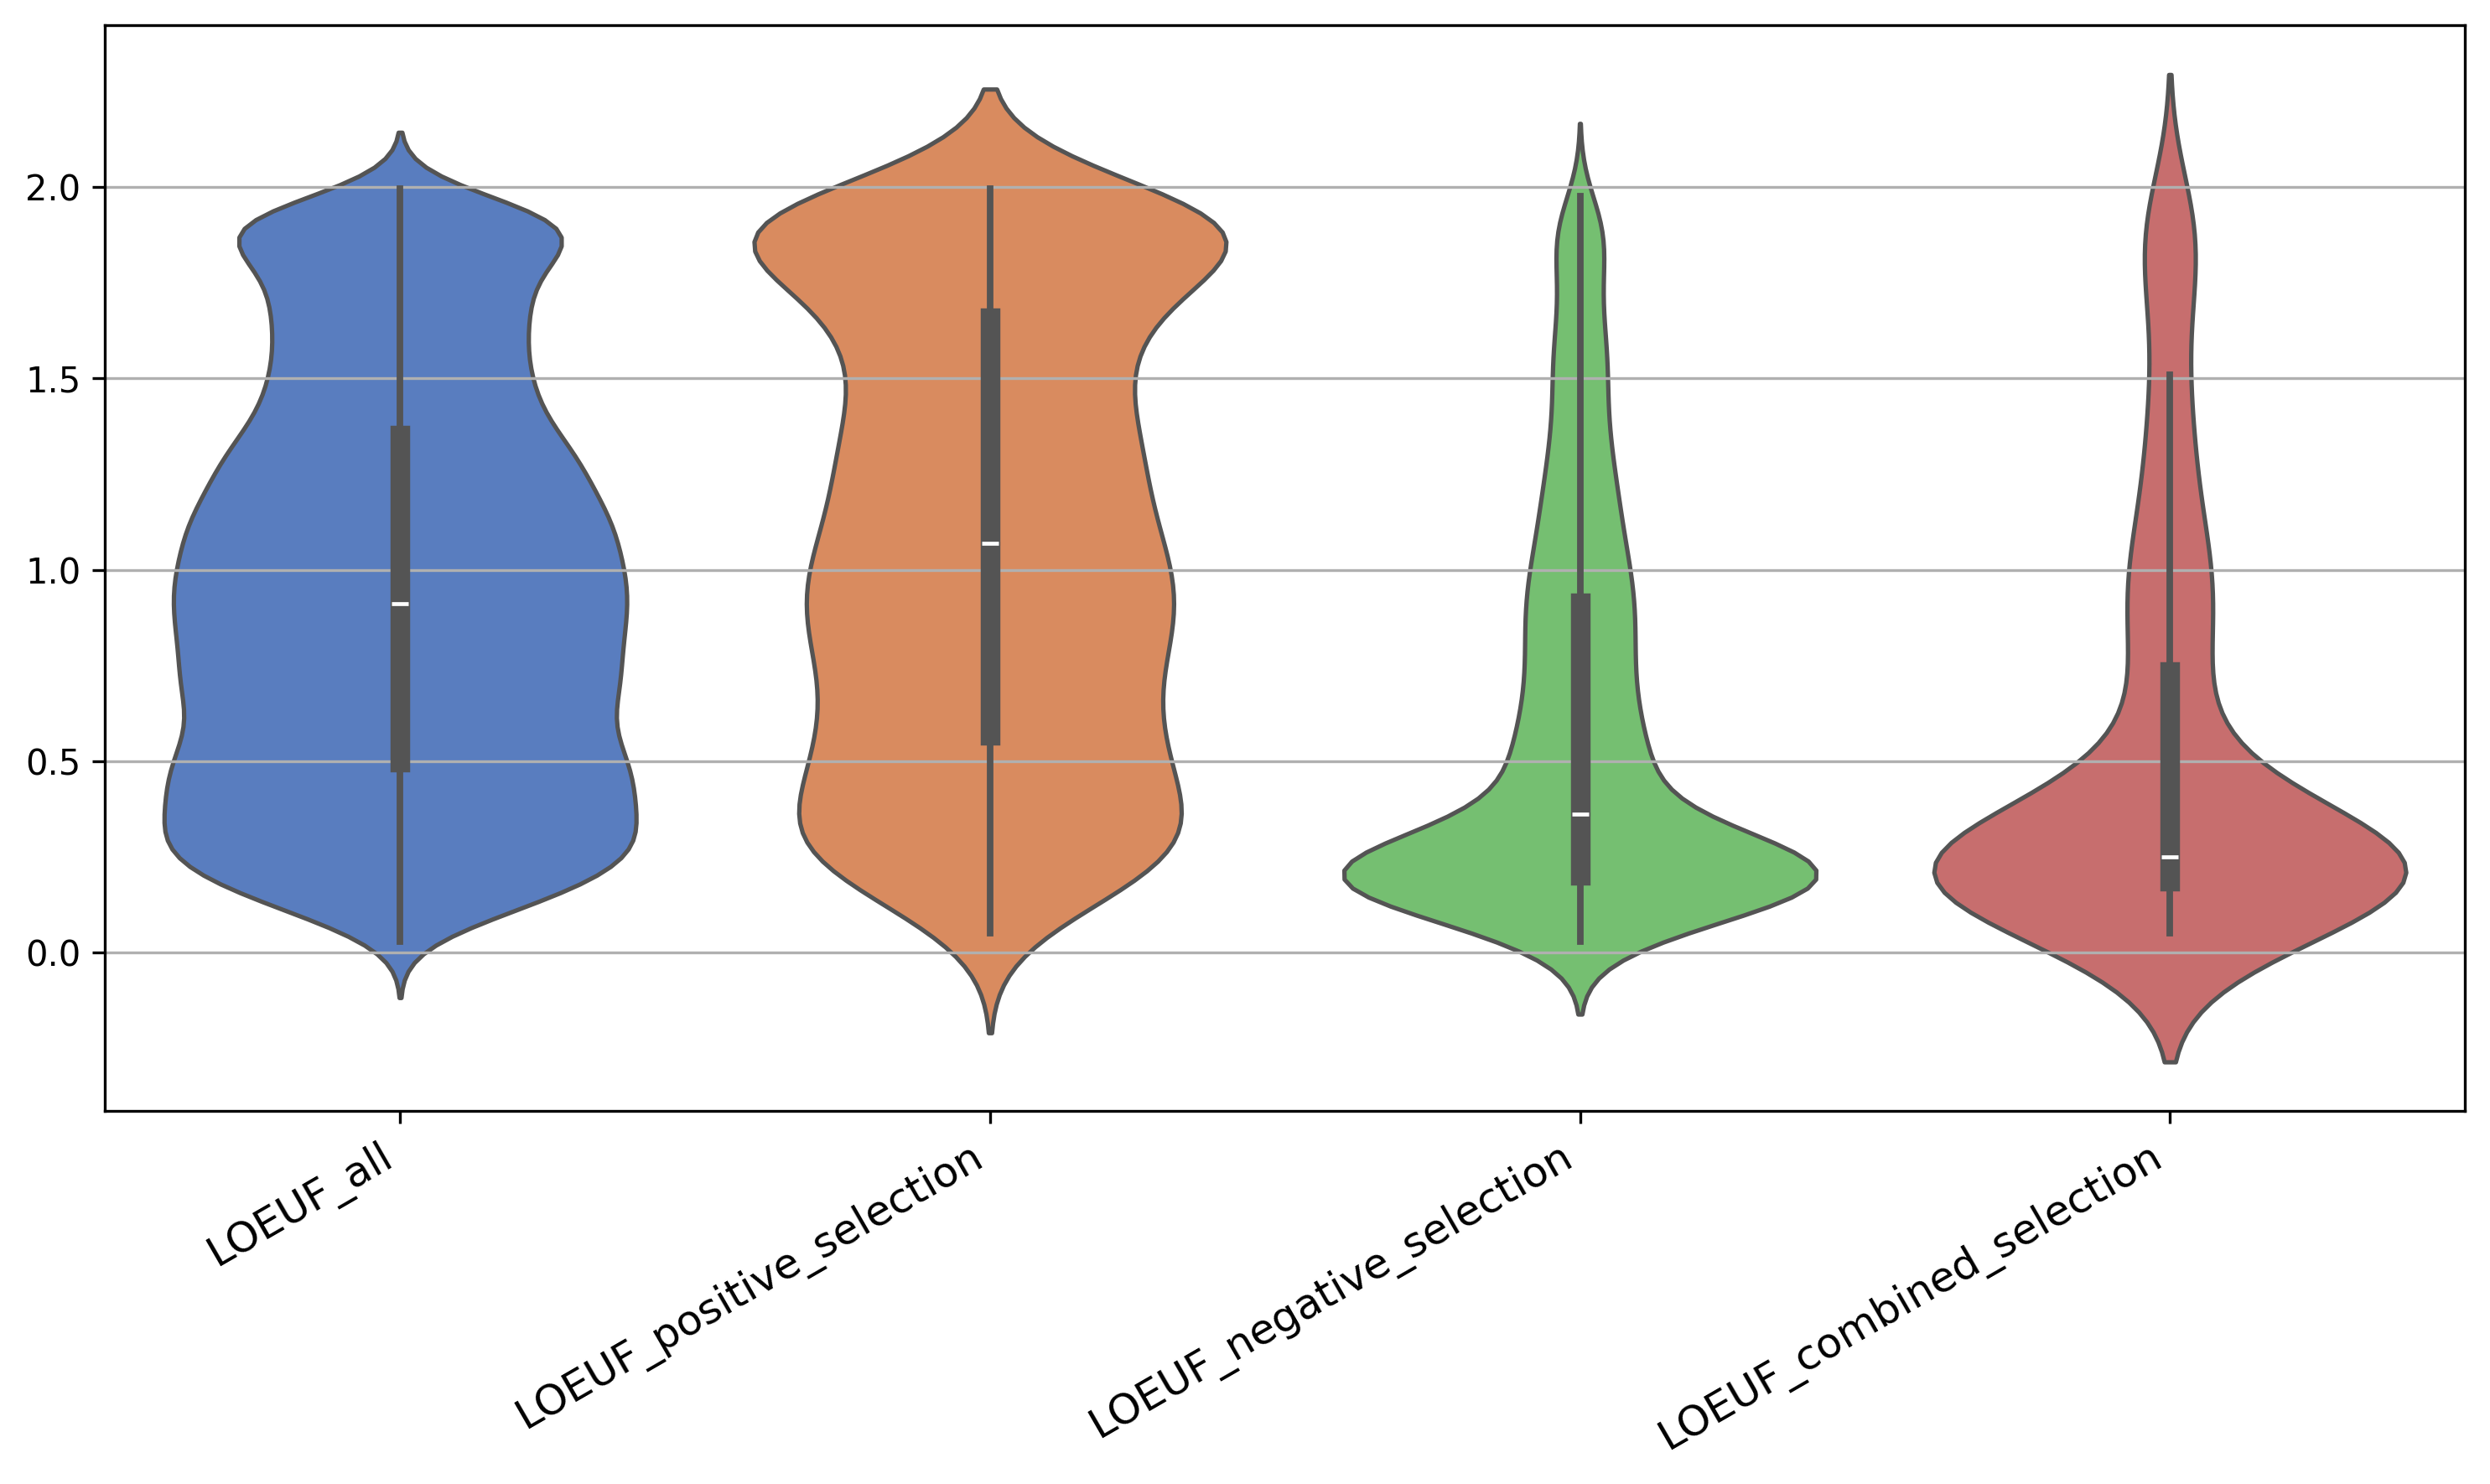

In [85]:
plt.figure(figsize=(10, 6), dpi=300)  
sns.violinplot(data=oe_plot, palette='muted')
plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### GERP++ RS and LOEUF

In [86]:
rs_oe_plot = rs_plot.join(oe_plot)
rs_oe_plot

,RS_all,RS_positive_selection,RS_negative_selection,RS_combined_selection,LOEUF_all,LOEUF_positive_selection,LOEUF_negative_selection,LOEUF_combined_selection
0,-0.221300,-0.221300,0.243900,0.243900,NaN,NaN,NaN,NaN
1,-0.233031,-0.200191,-0.294835,-0.615064,NaN,NaN,0.145,0.245
2,-0.189201,0.243900,-0.615064,-0.755862,NaN,NaN,0.245,0.187
3,-0.200191,0.136936,-0.396894,-0.390252,NaN,1.84,0.194,0.172
4,-0.199254,-0.114585,0.198424,0.266714,NaN,NaN,1.344,NaN
...,...,...,...,...,...,...,...,...
57855,-0.290134,NaN,NaN,NaN,1.868,NaN,NaN,NaN
57856,-0.134897,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57857,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57858,-0.142133,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
rs_oe_plot = rs_oe_plot[['RS_all', 'LOEUF_all', 'RS_positive_selection', 'LOEUF_positive_selection', 
'RS_negative_selection', 'LOEUF_negative_selection', 'RS_combined_selection', 'LOEUF_combined_selection']]

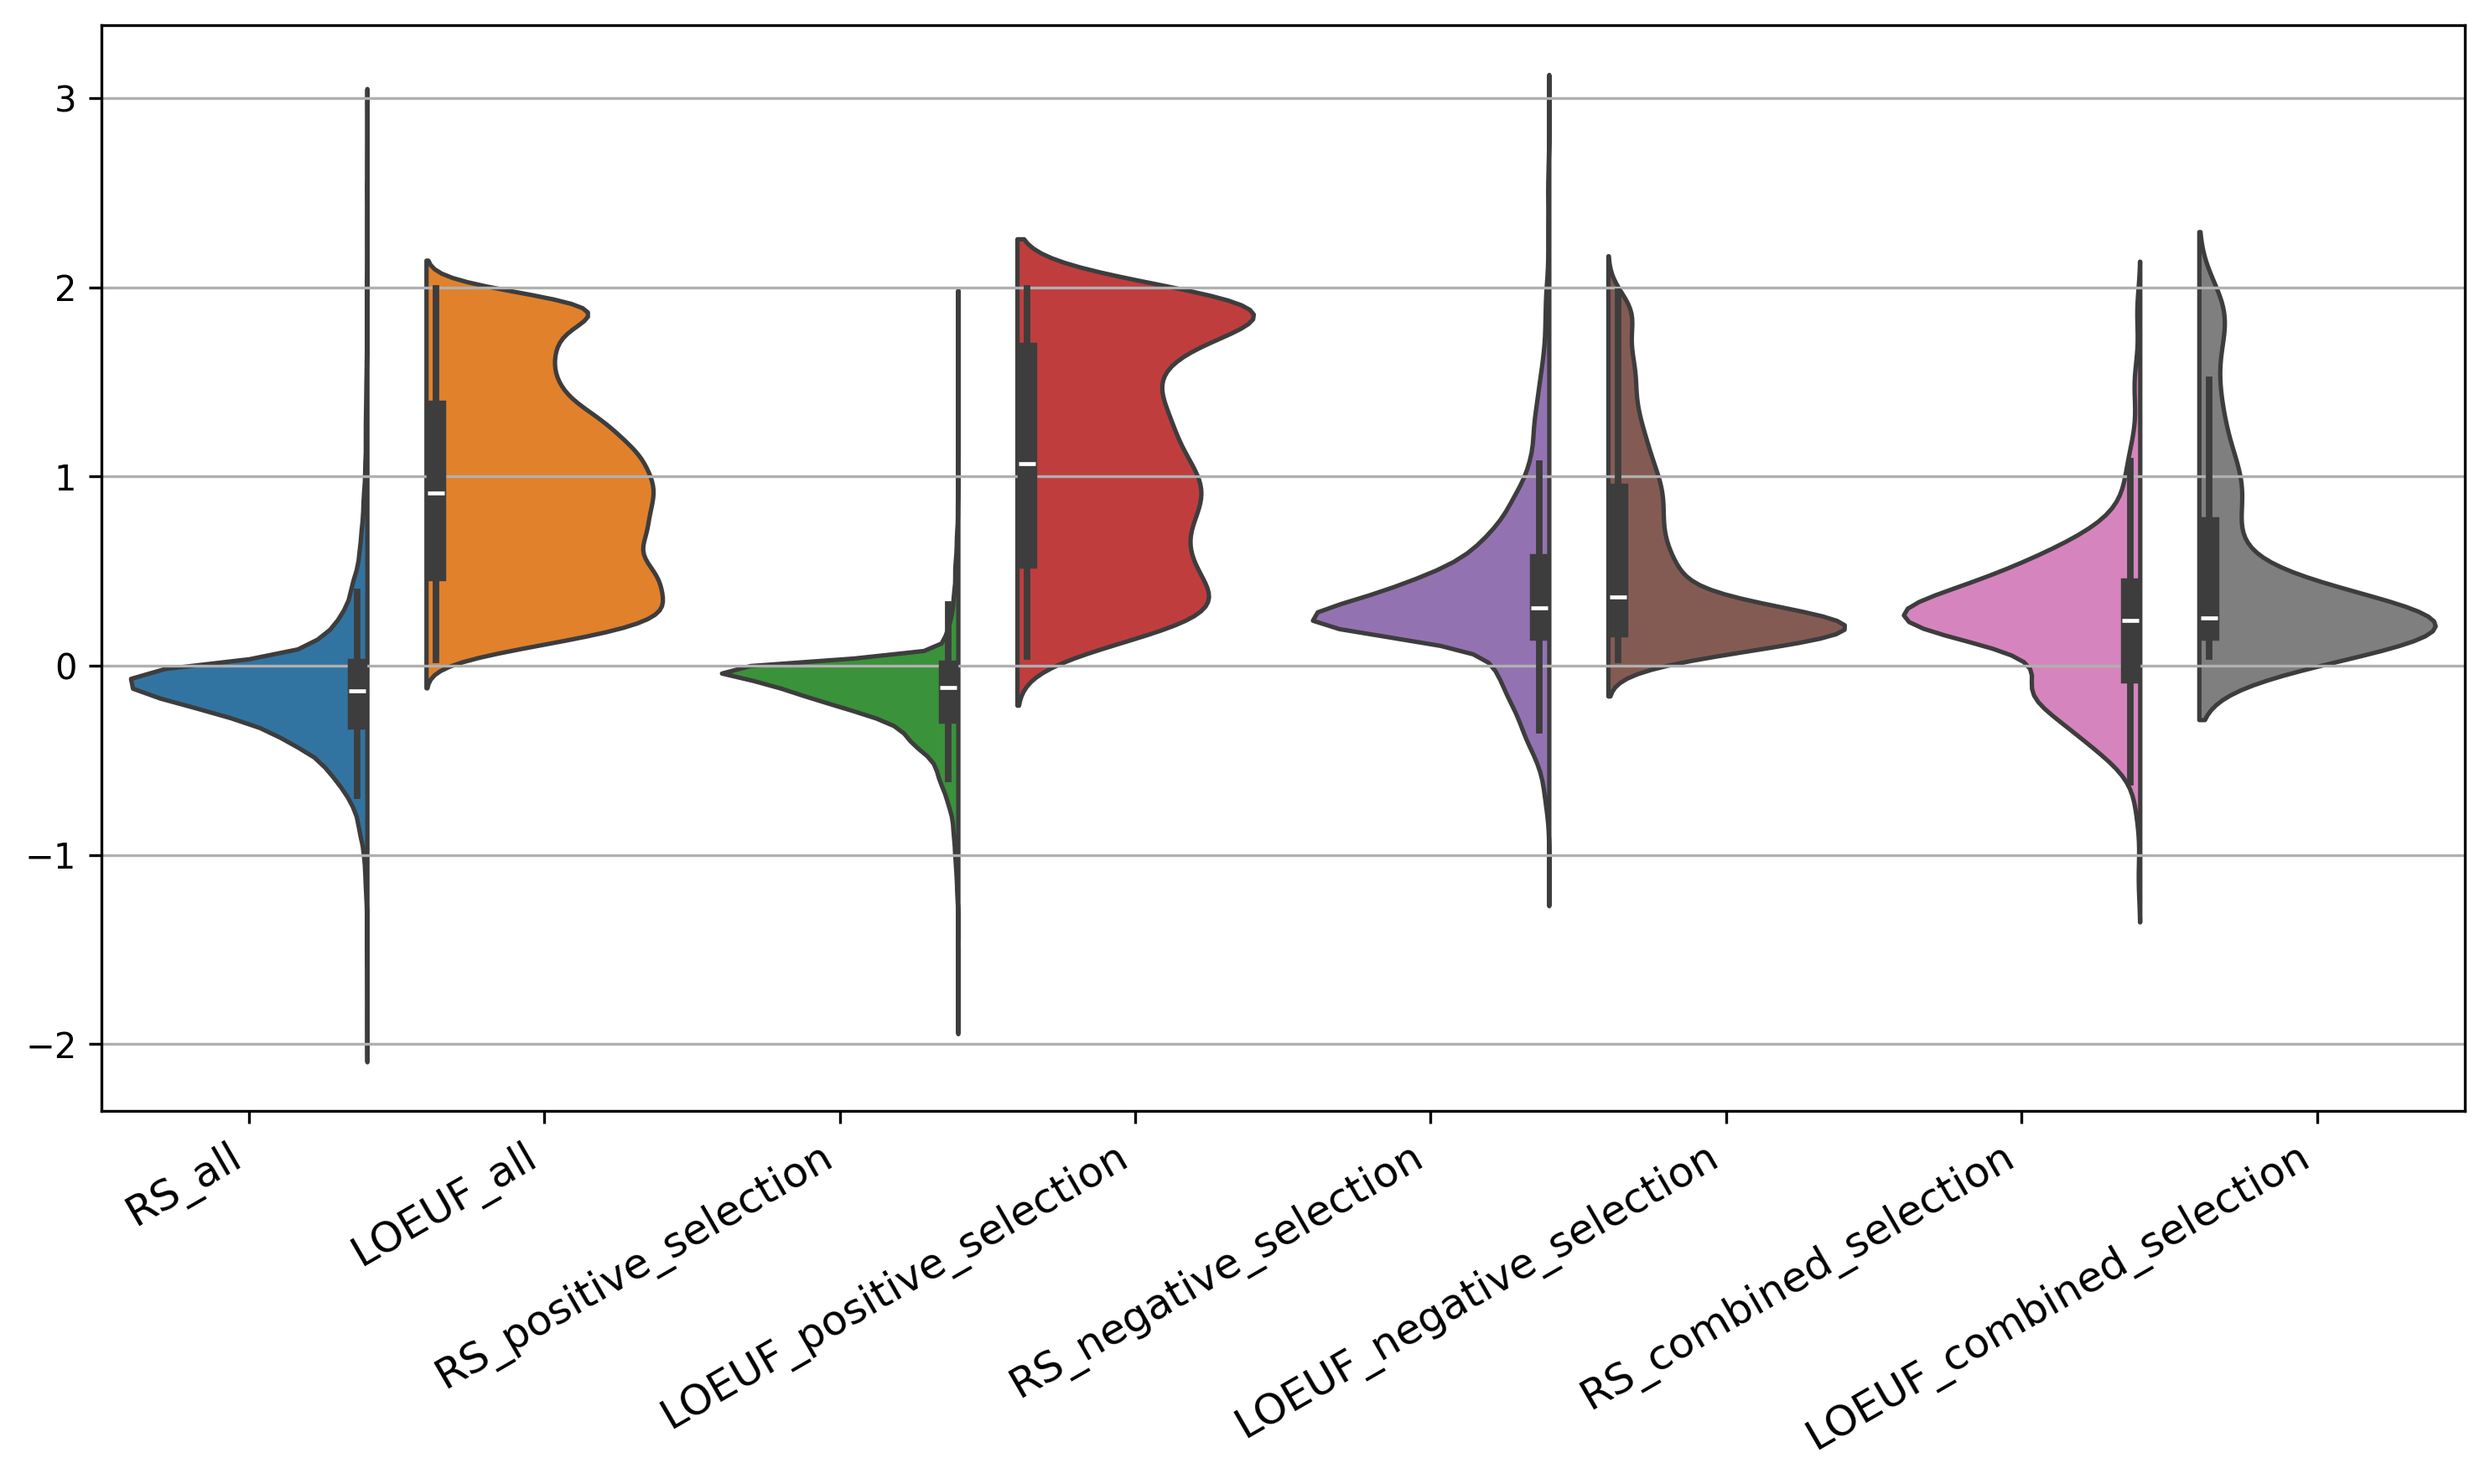

In [88]:
plt.figure(figsize=(10, 6), dpi=300)
sns.violinplot(data=rs_oe_plot,        
               split=True) 

plt.xticks(rotation=30, ha='right', fontsize=12)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()